<a href="https://colab.research.google.com/github/ktugceerdemli/GlobalAIHubProject/blob/main/medicalAppointment(Supervised_Unsupervised).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'noshowappointments:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F792%2F3538%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240919%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240919T161923Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da4021c062104f8c002cb5c4fa9396075044a0854ce35560f2abffec54b75c83c2a6136f70996f9c3f7ceadeb6eb7478db1ec481b8a5b455f904dd58c54da9bdf7e3521a29cc9df1cdd60f64df8c468767ff788b1357ef80a4566586da24170974610a8e838c15d5b3b6b63481f4b0b7dfc833425ffc453775b1badd76f86ac82c66fbc5e6e40061d955849ac875b4f8fe5055722ef274e0aa72c3264be6567aadfb8d0254a0479725d95227f53706a502f4f48c383e7be504cea14a195fb510a1fa6d70ce1067fe71e2e868b5a2293b990129413d8bb6040f240b72b6e90e5f25f23f3d683bcf5cf99bb28d08fa035d2ff035ebac0b8ce63e59c048a513bfa51'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# **Medical Appointment Dataset**

It's a medical appointment dataset which contains 110.527 data with 14 variables. The aim of this data set is try to understand patient why not showing up their appointment.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/noshowappointments/KaggleV2-May-2016.csv


In [ ]:

#Import Libraries
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import optuna

In [ ]:
# Load the dataset
file_path = '/kaggle/input/noshowappointments/KaggleV2-May-2016.csv'

df = pd.read_csv(file_path, low_memory=False)


In [ ]:
#Look at the general info about dataset with check_df function
def check_df(dataframe, head=5):
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Number of unique #####################")
    print(dataframe.nunique())
    print("##################### Descriptive Statistics #####################")
    print(dataframe.describe().T)

check_df(df)

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None
##################### Shape ########


PatientId : The number of patient is 62299.

AppointmentID : Unique number for each appointment.

Gender : Male or Female

ScheduledDay : The day patient get scheduled for appointment

AppointmentDay: The day patient visit doctor

Age: Age of the patient

Neighbourhood: Where the appointment takes place

Scholarship: Financial Aid

Hipertension, Diabetes, Alcoholism: Illneess

Handcap: Allowance

SMS_received: Send sms to patient

No-show: No or Yes to show up appointment

# **Pre-processing Data**

In [ ]:
#Turn to datetime type necessary columns

datetime_col = ["ScheduledDay","AppointmentDay"]

for col in datetime_col:
    df[col] = pd.to_datetime(df[col]).dt.strftime('%Y-%m-%d')
    df[col] = pd.to_datetime(df[col])

df["ScheduledDay"].head()

0   2016-04-29
1   2016-04-29
2   2016-04-29
3   2016-04-29
4   2016-04-29
Name: ScheduledDay, dtype: datetime64[ns]

In [ ]:
#Delete Age == -1 column shown in describe data
age_drop = df[df["Age"] == -1]
df.drop(index= age_drop.index, inplace= True)
df.shape

(110526, 14)

In [ ]:
#Drop duplicates if it is in data
df.duplicated().sum()

0

In [ ]:
#AppointmentID is unique for each line like an index so drop it
df.drop(columns = ["AppointmentID"], inplace= True)
df.shape

(110526, 13)

# **EDA**

In [ ]:
# Identify categoric and numeric values
def grab_col_names(dataframe, cat_th=12, car_th=90):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtype != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtype == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != "O" and dataframe[col].dtype != "datetime64[ns]"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)
print(f"Categorical Columns:", cat_cols)
print(f"Numerical Columns:", num_cols)
print(f"Cardinal Columns:", cat_but_car)

Categorical Columns: ['Gender', 'Neighbourhood', 'No-show', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
Numerical Columns: ['PatientId', 'Age']
Cardinal Columns: []


Column name:  Gender
###########
        Gender      Ratio
Gender                   
F        71839  64.997376
M        38687  35.002624


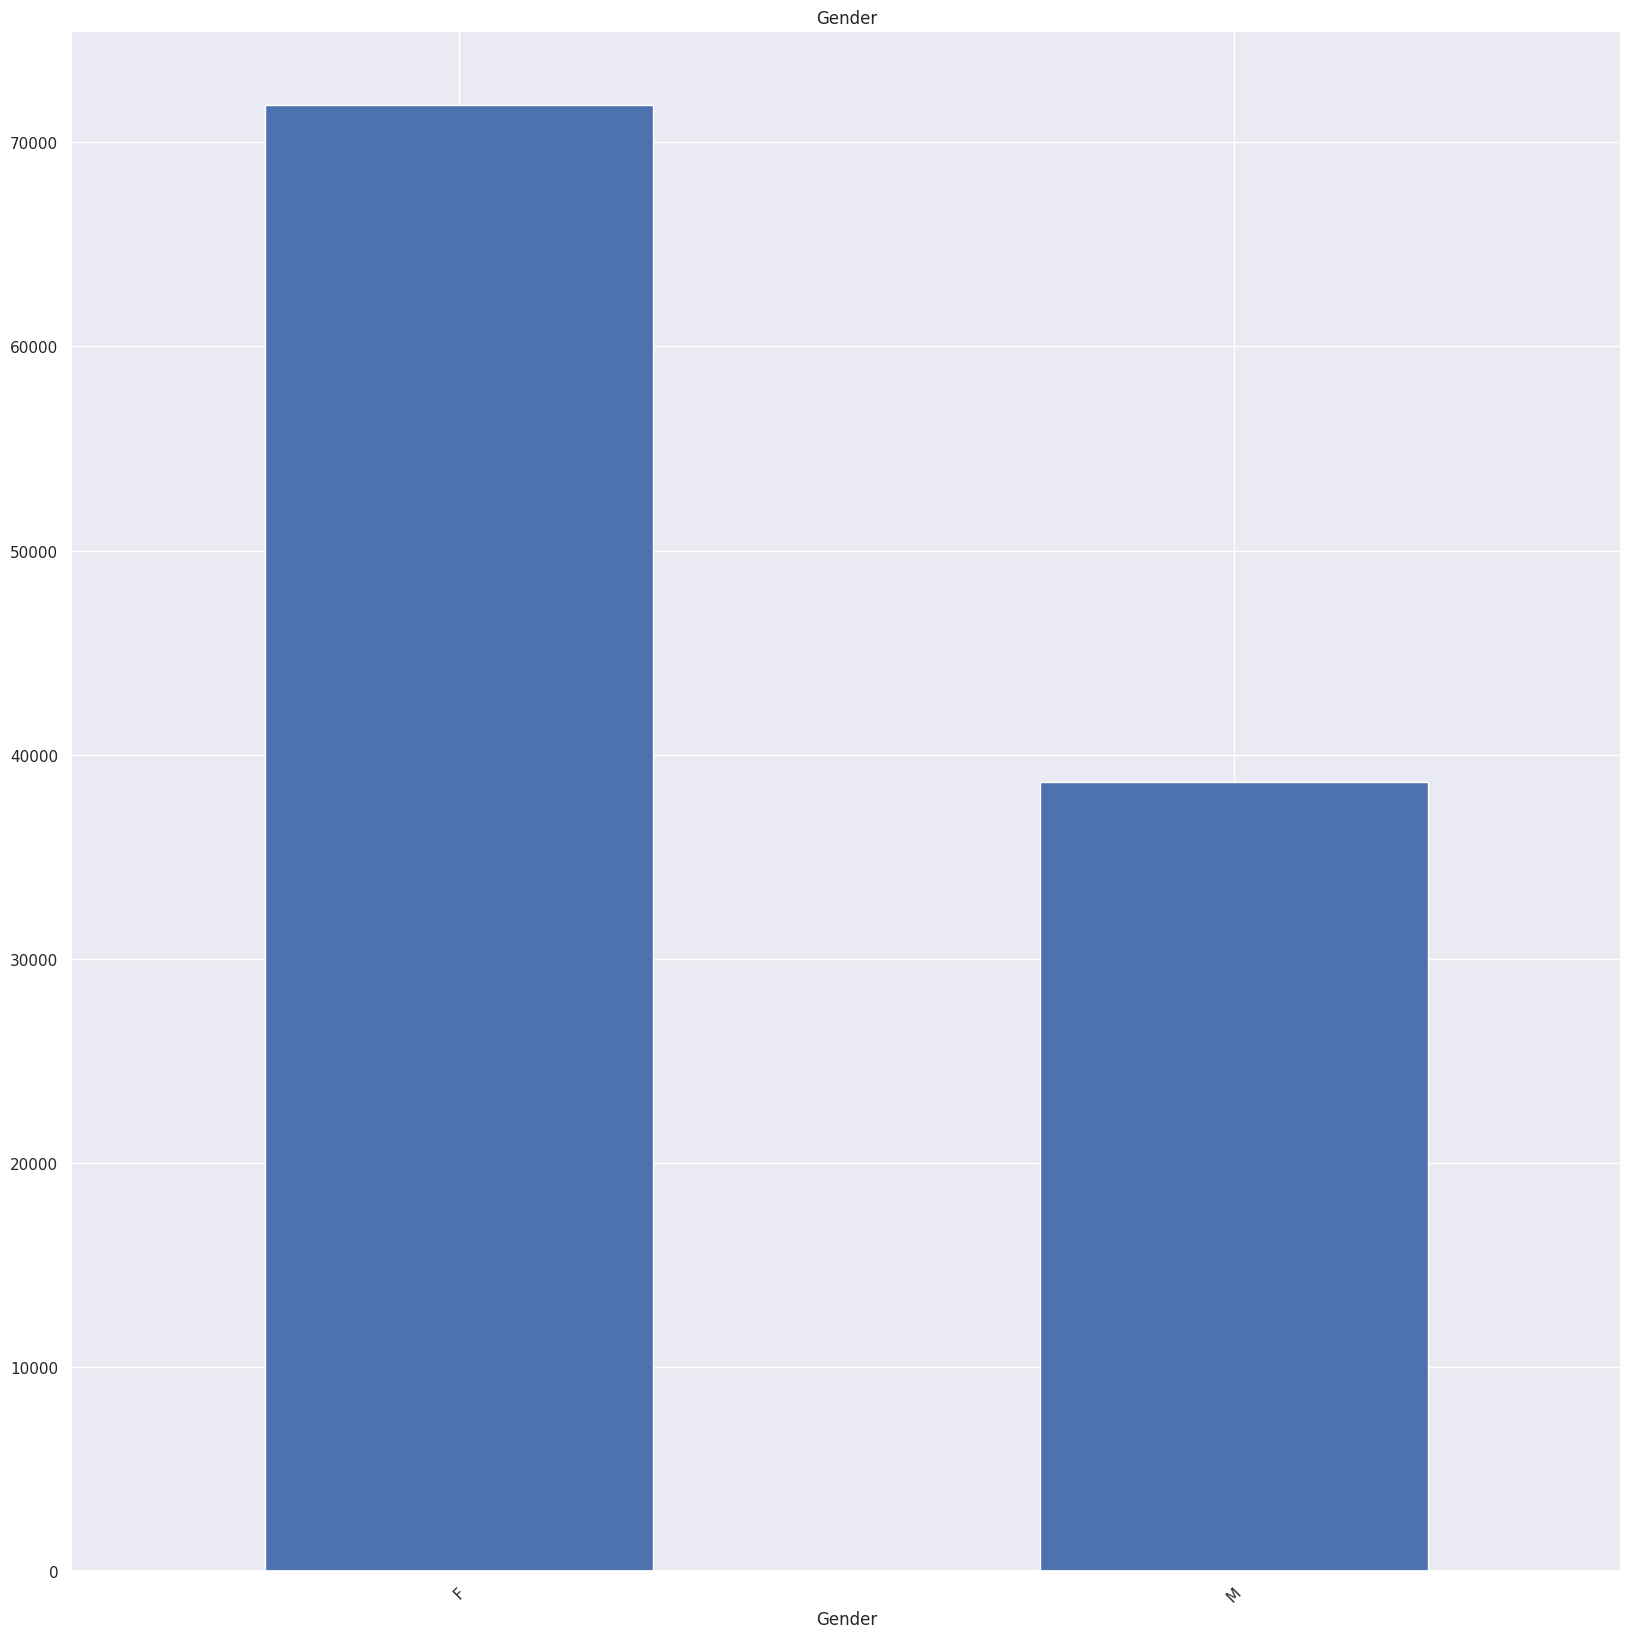

--------------------------------------------------------------------------

Column name:  Neighbourhood
###########
                             Neighbourhood     Ratio
Neighbourhood                                       
JARDIM CAMBURI                        7717  6.982068
MARIA ORTIZ                           5805  5.252158
RESISTÊNCIA                           4431  4.009011
JARDIM DA PENHA                       3877  3.507772
ITARARÉ                               3514  3.179342
...                                    ...       ...
ILHA DO BOI                             35  0.031667
ILHA DO FRADE                           10  0.009048
AEROPORTO                                8  0.007238
ILHAS OCEÂNICAS DE TRINDADE              2  0.001810
PARQUE INDUSTRIAL                        1  0.000905

[81 rows x 2 columns]


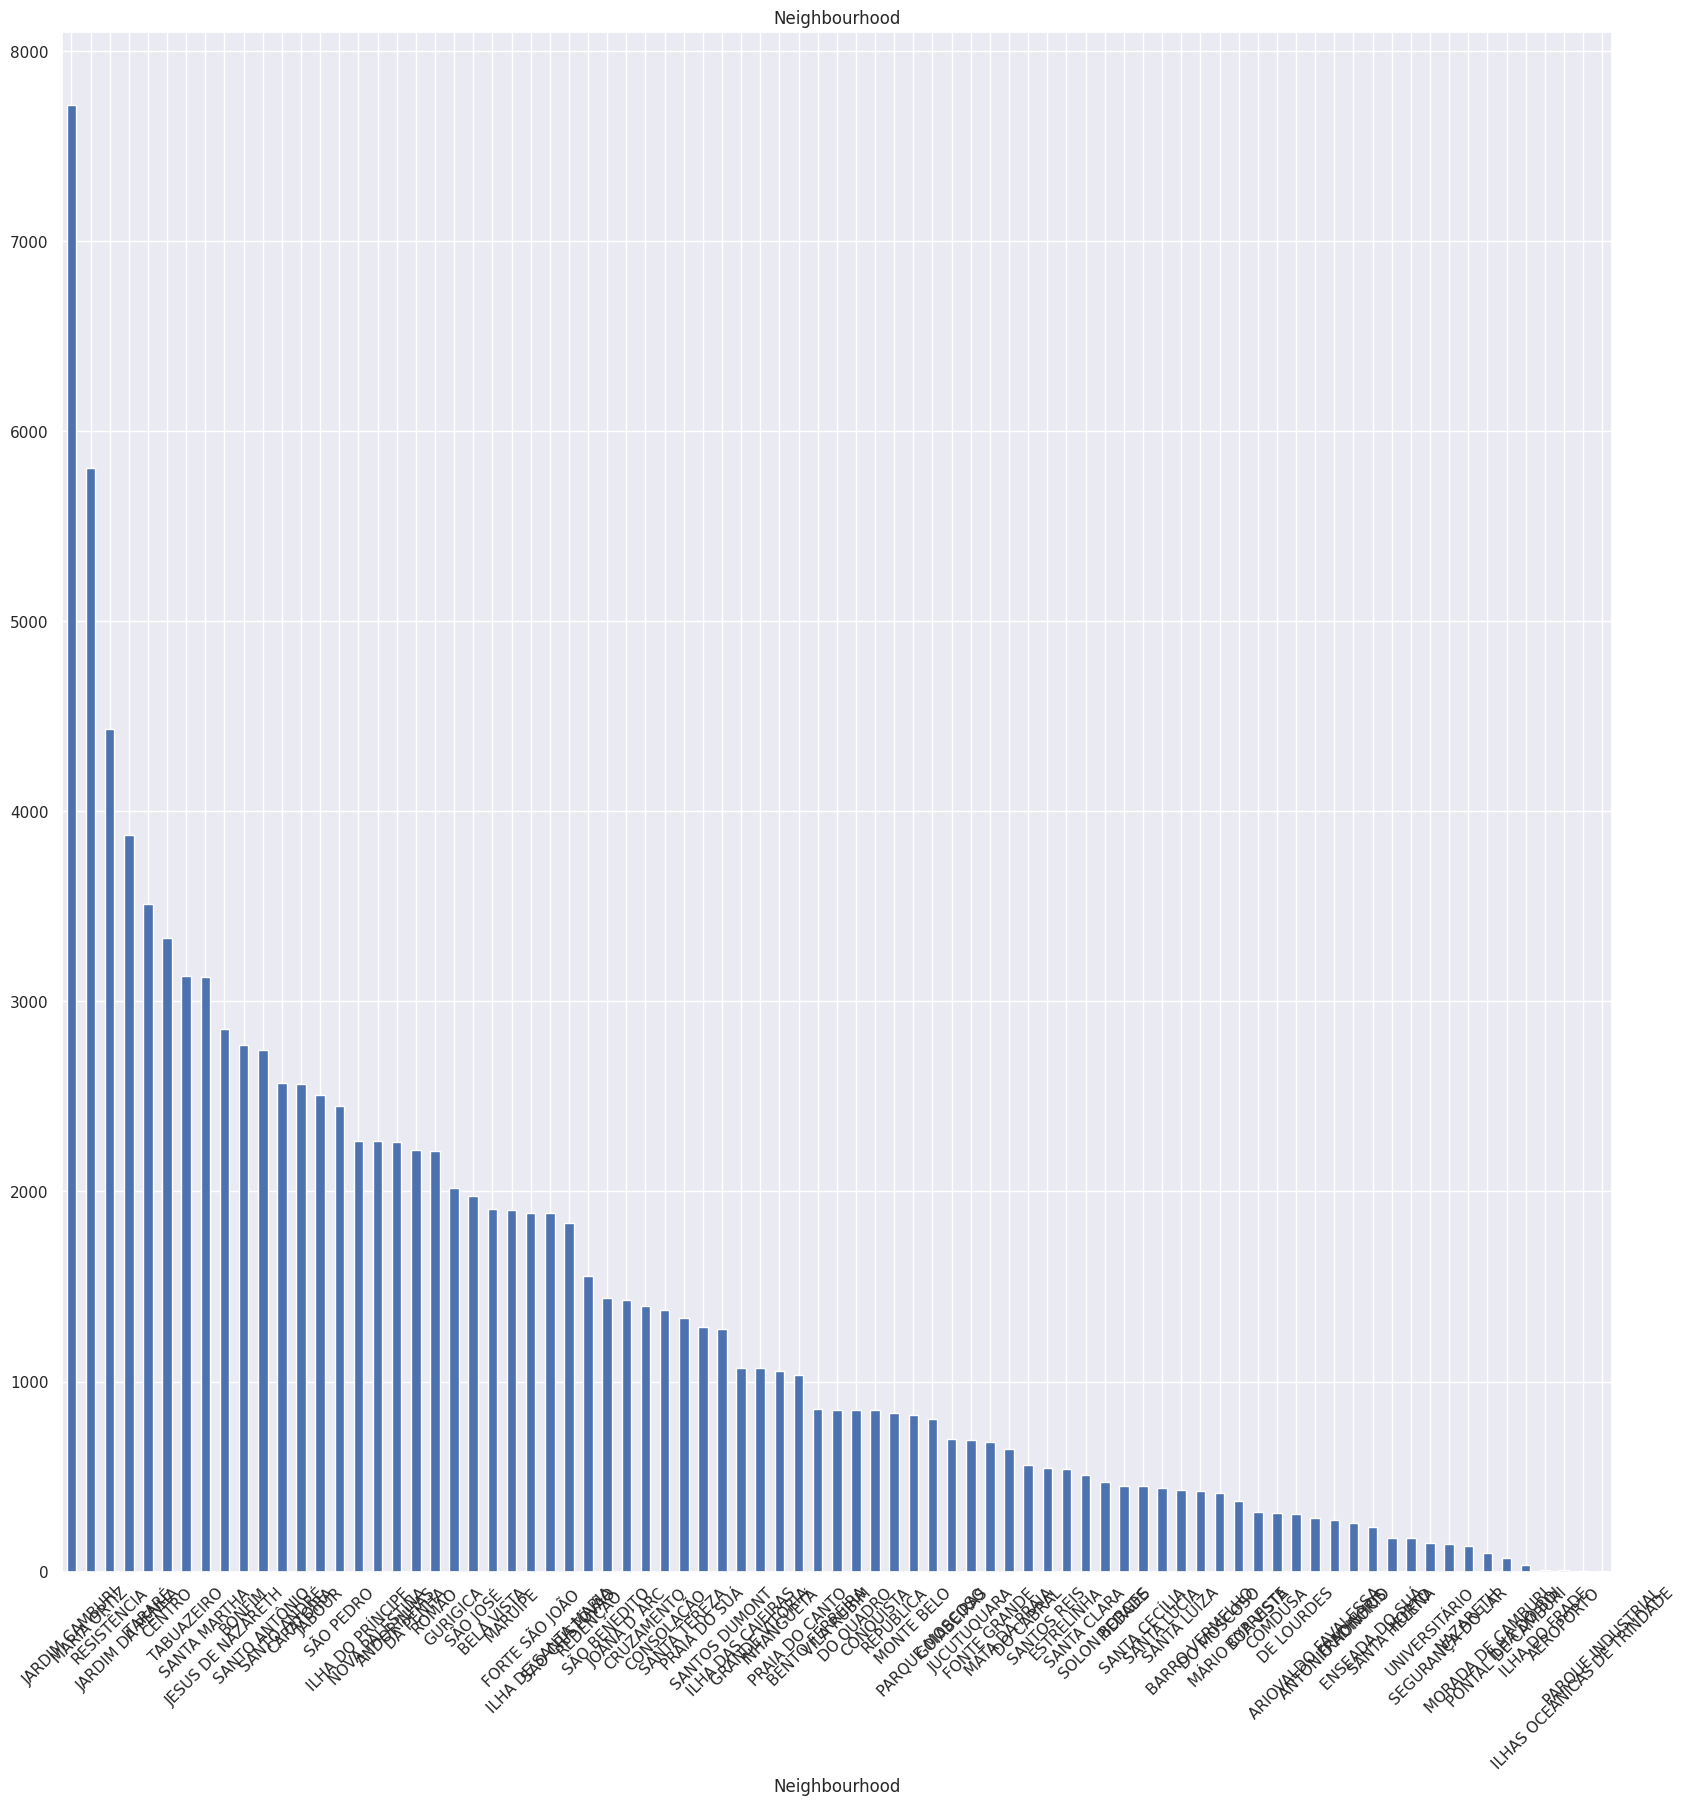

--------------------------------------------------------------------------

Column name:  No-show
###########
         No-show      Ratio
No-show                    
No         88207  79.806561
Yes        22319  20.193439


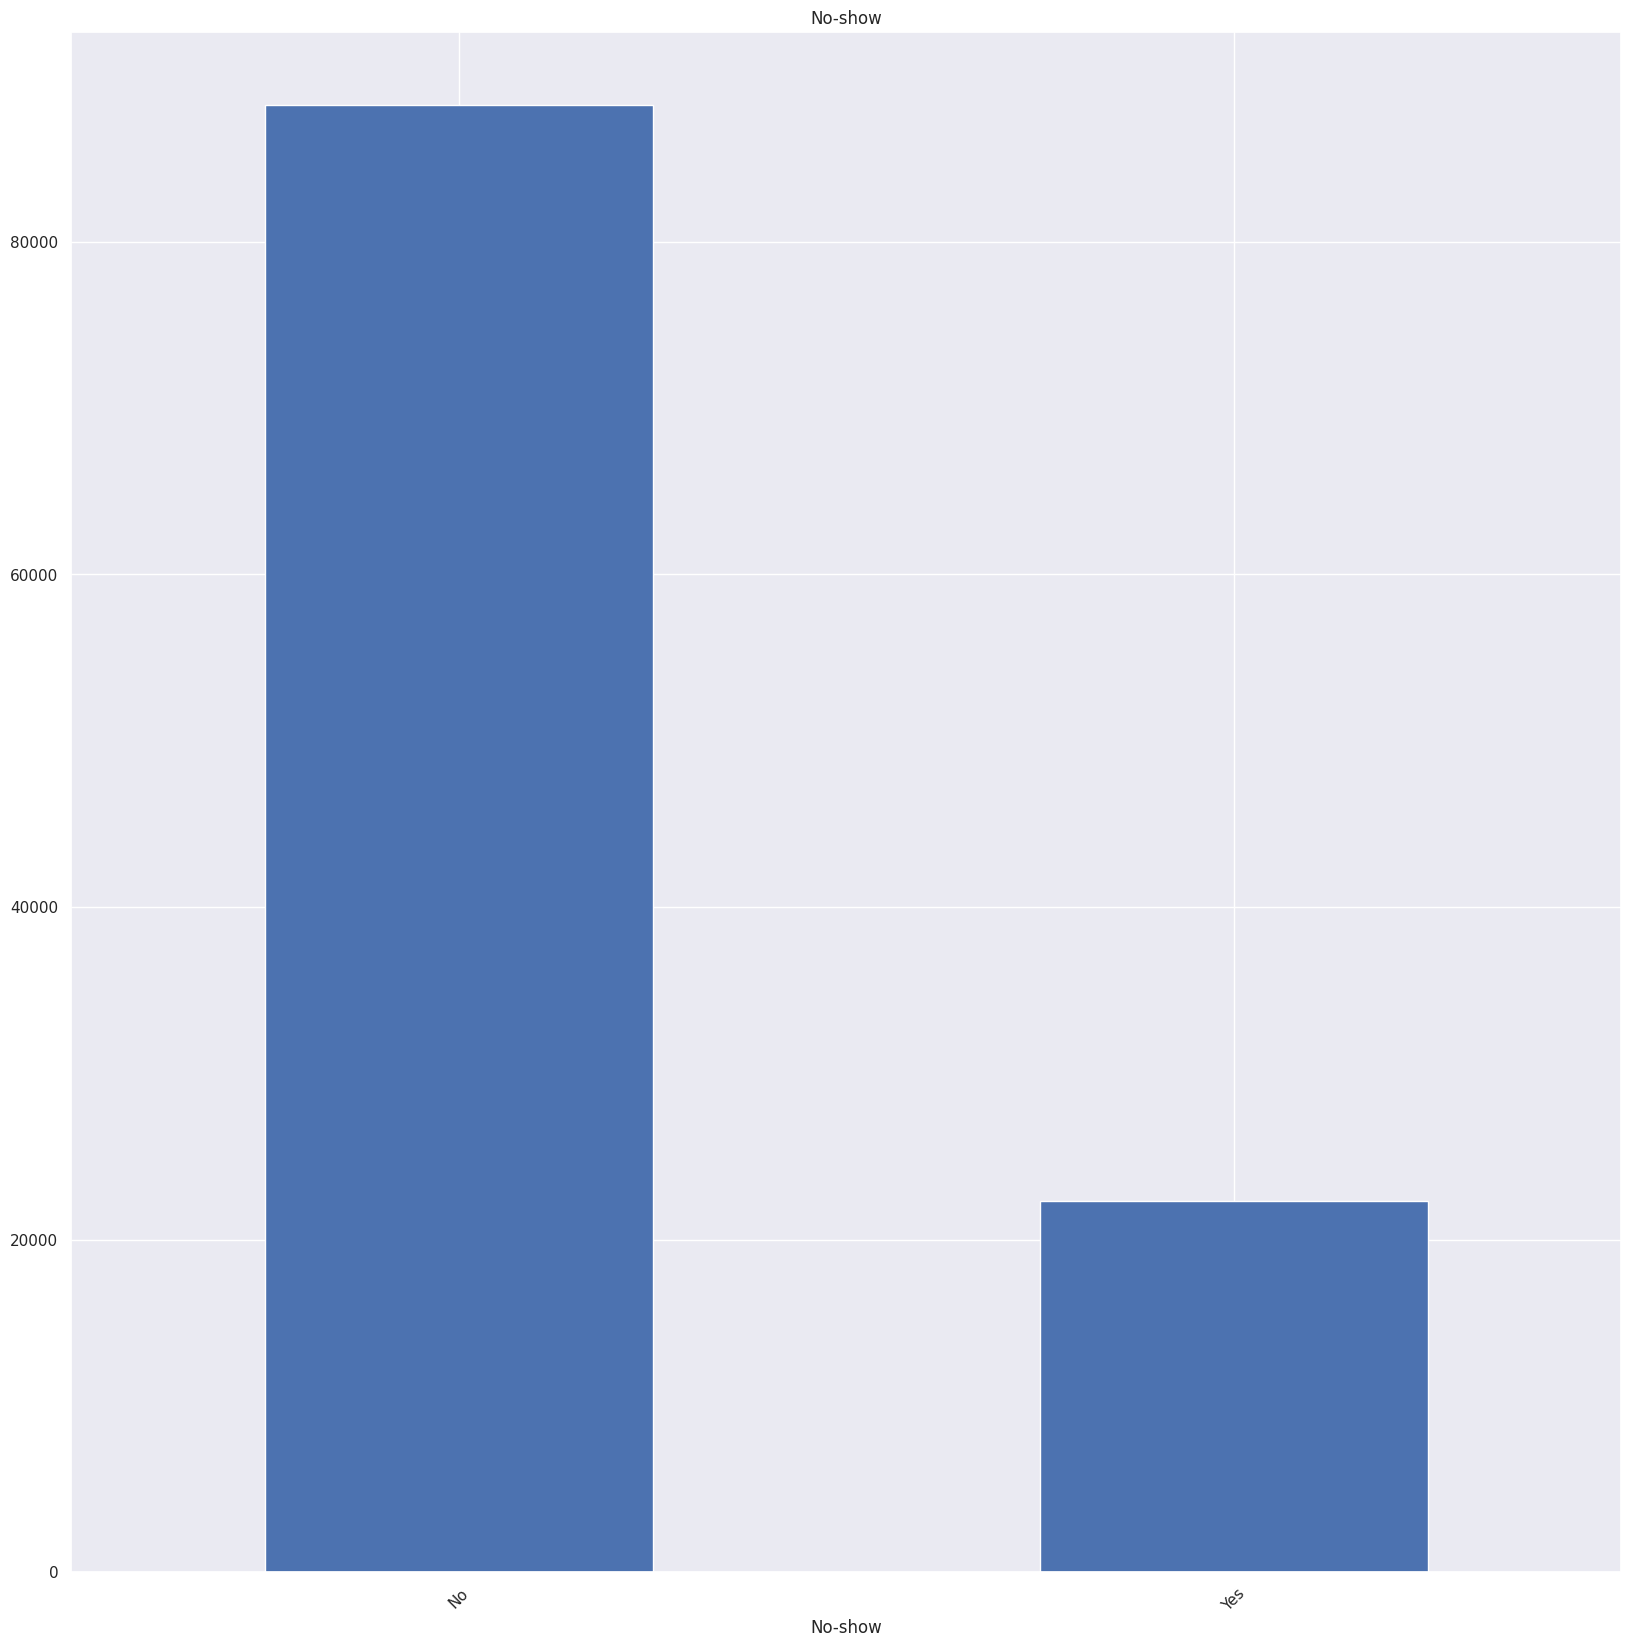

--------------------------------------------------------------------------

Column name:  Scholarship
###########
             Scholarship      Ratio
Scholarship                        
0                  99665  90.173353
1                  10861   9.826647


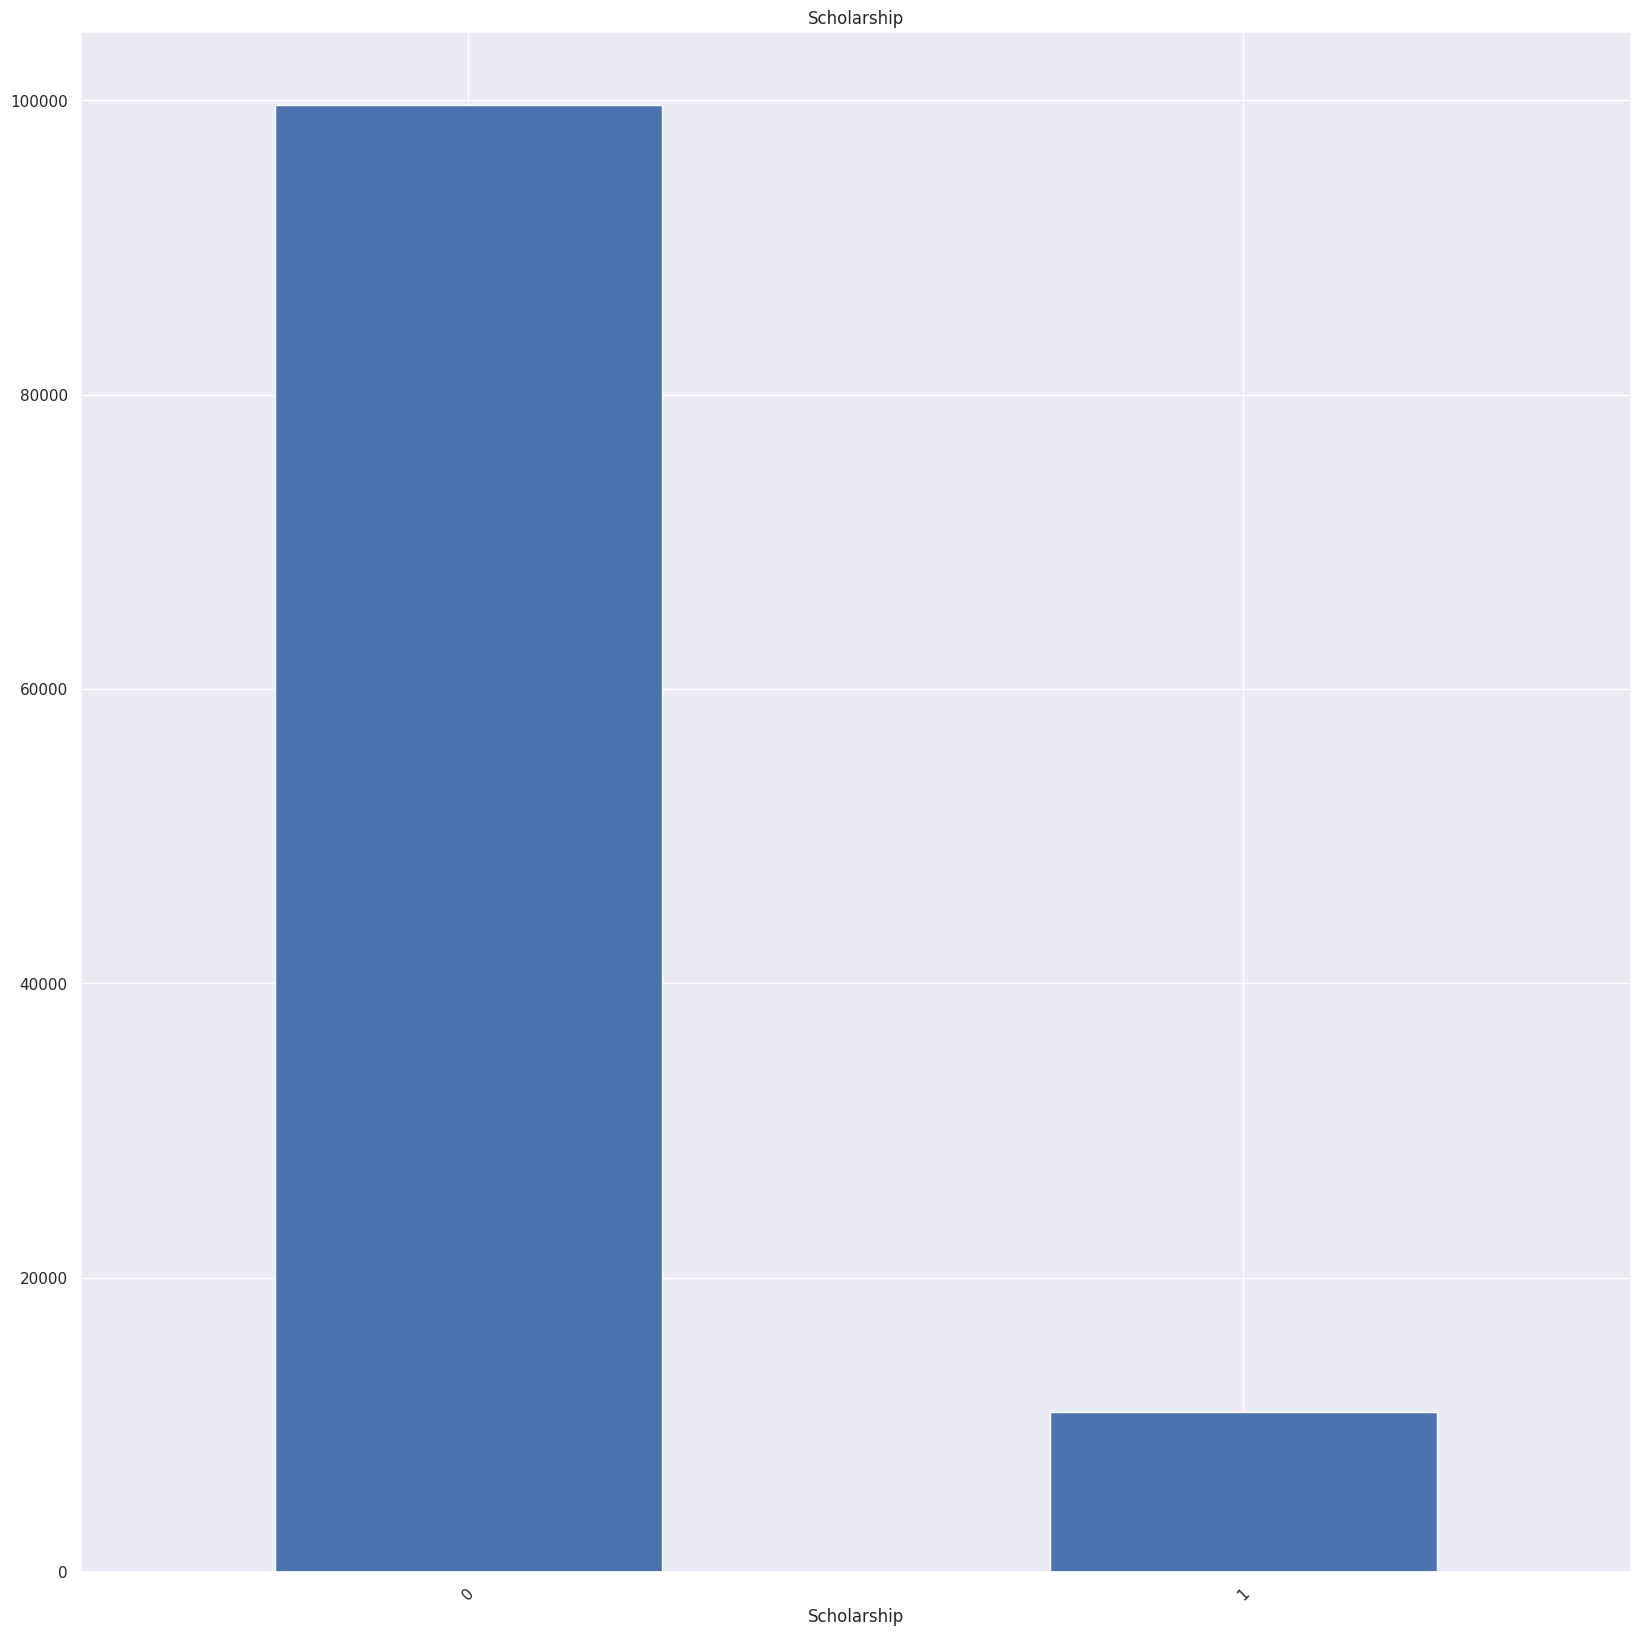

--------------------------------------------------------------------------

Column name:  Hipertension
###########
              Hipertension      Ratio
Hipertension                         
0                    88725  80.275229
1                    21801  19.724771


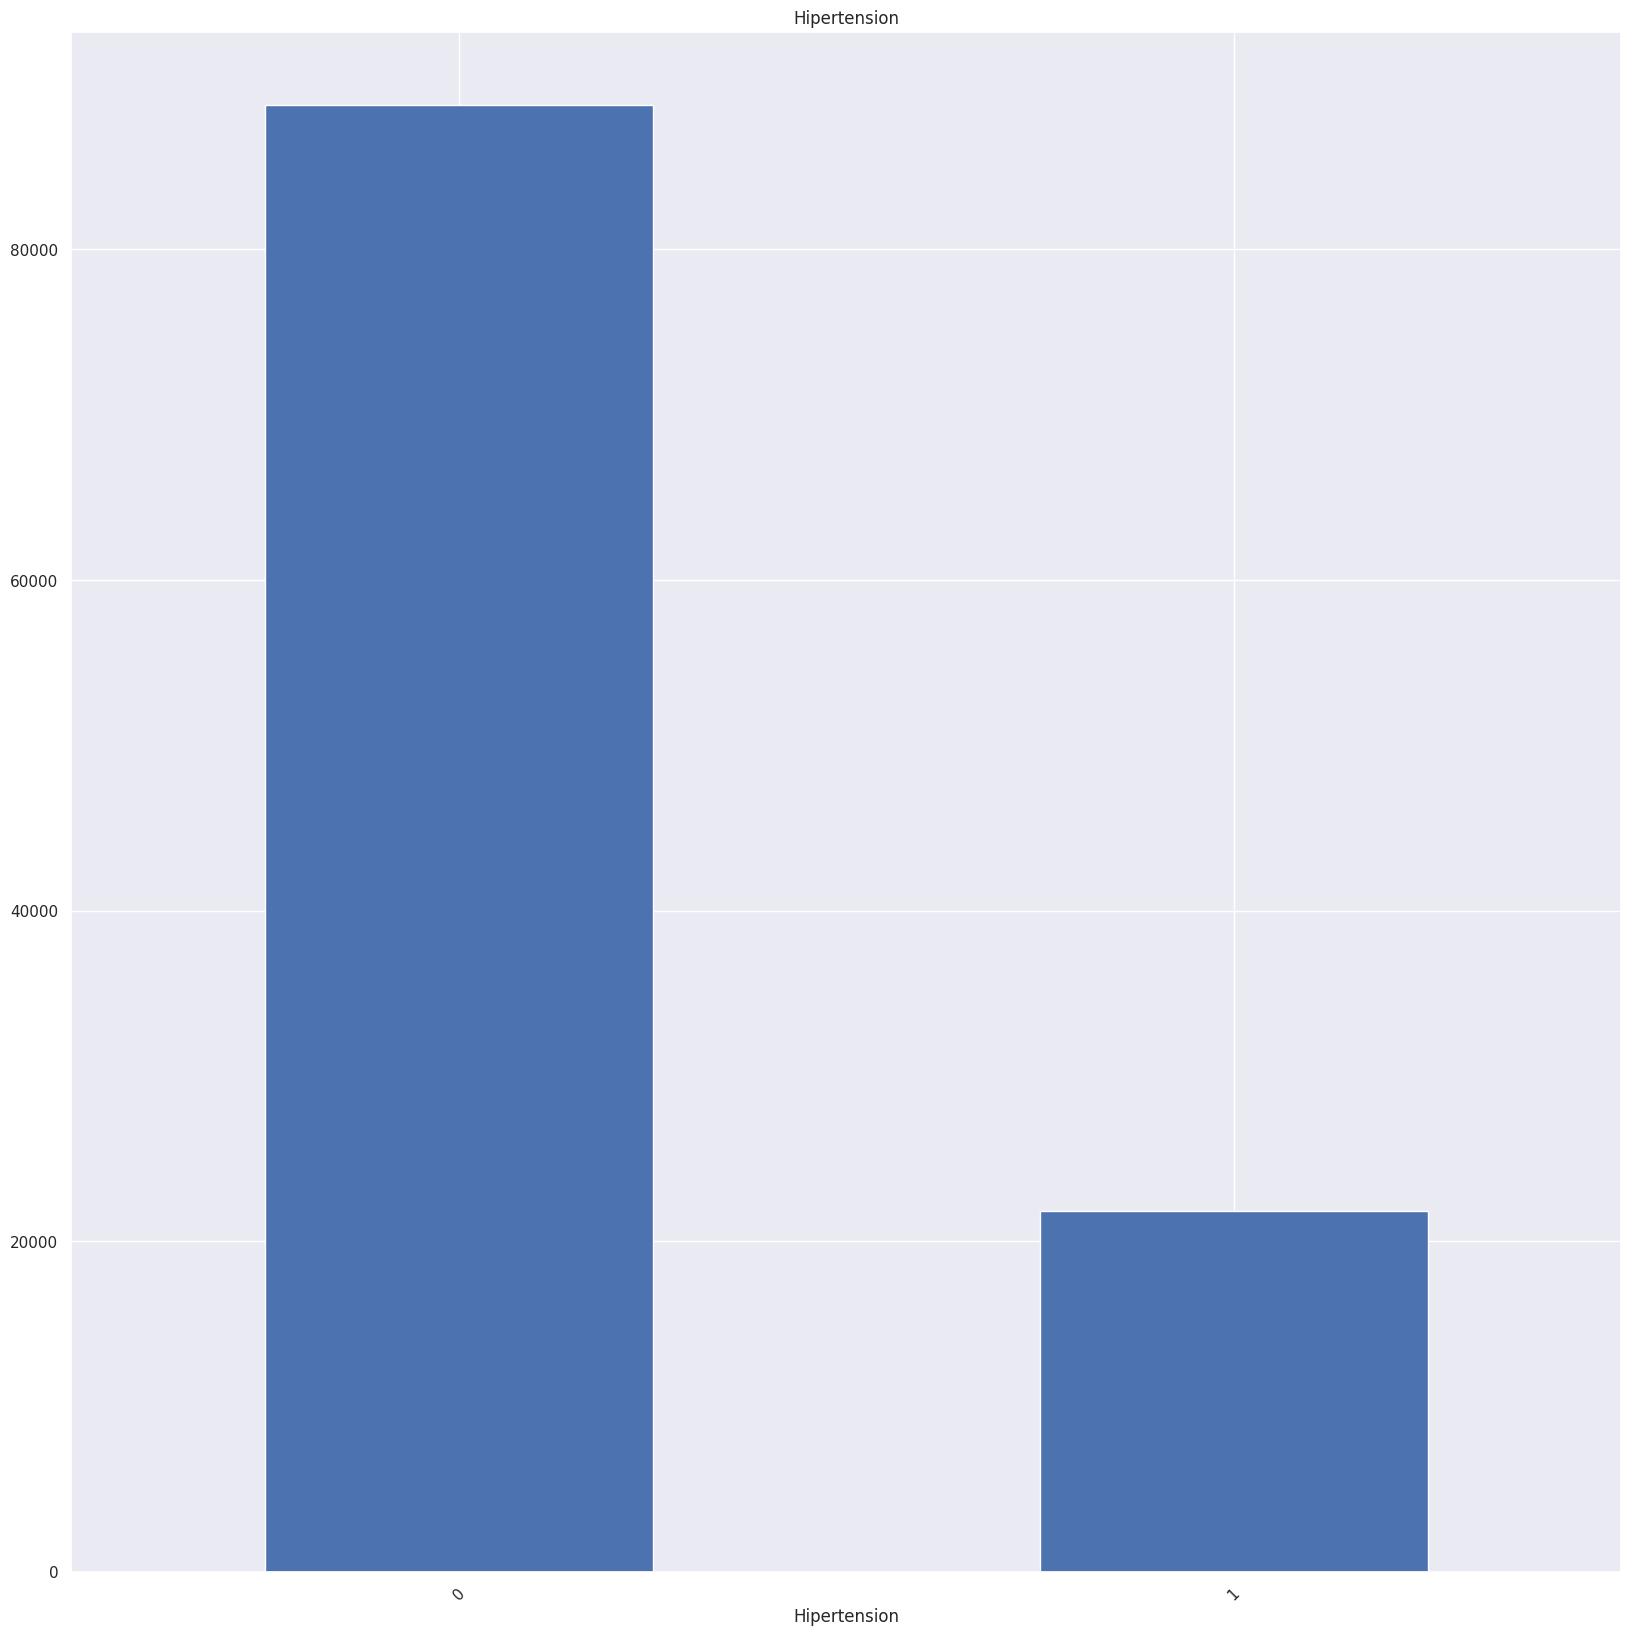

--------------------------------------------------------------------------

Column name:  Diabetes
###########
          Diabetes      Ratio
Diabetes                     
0           102583  92.813456
1             7943   7.186544


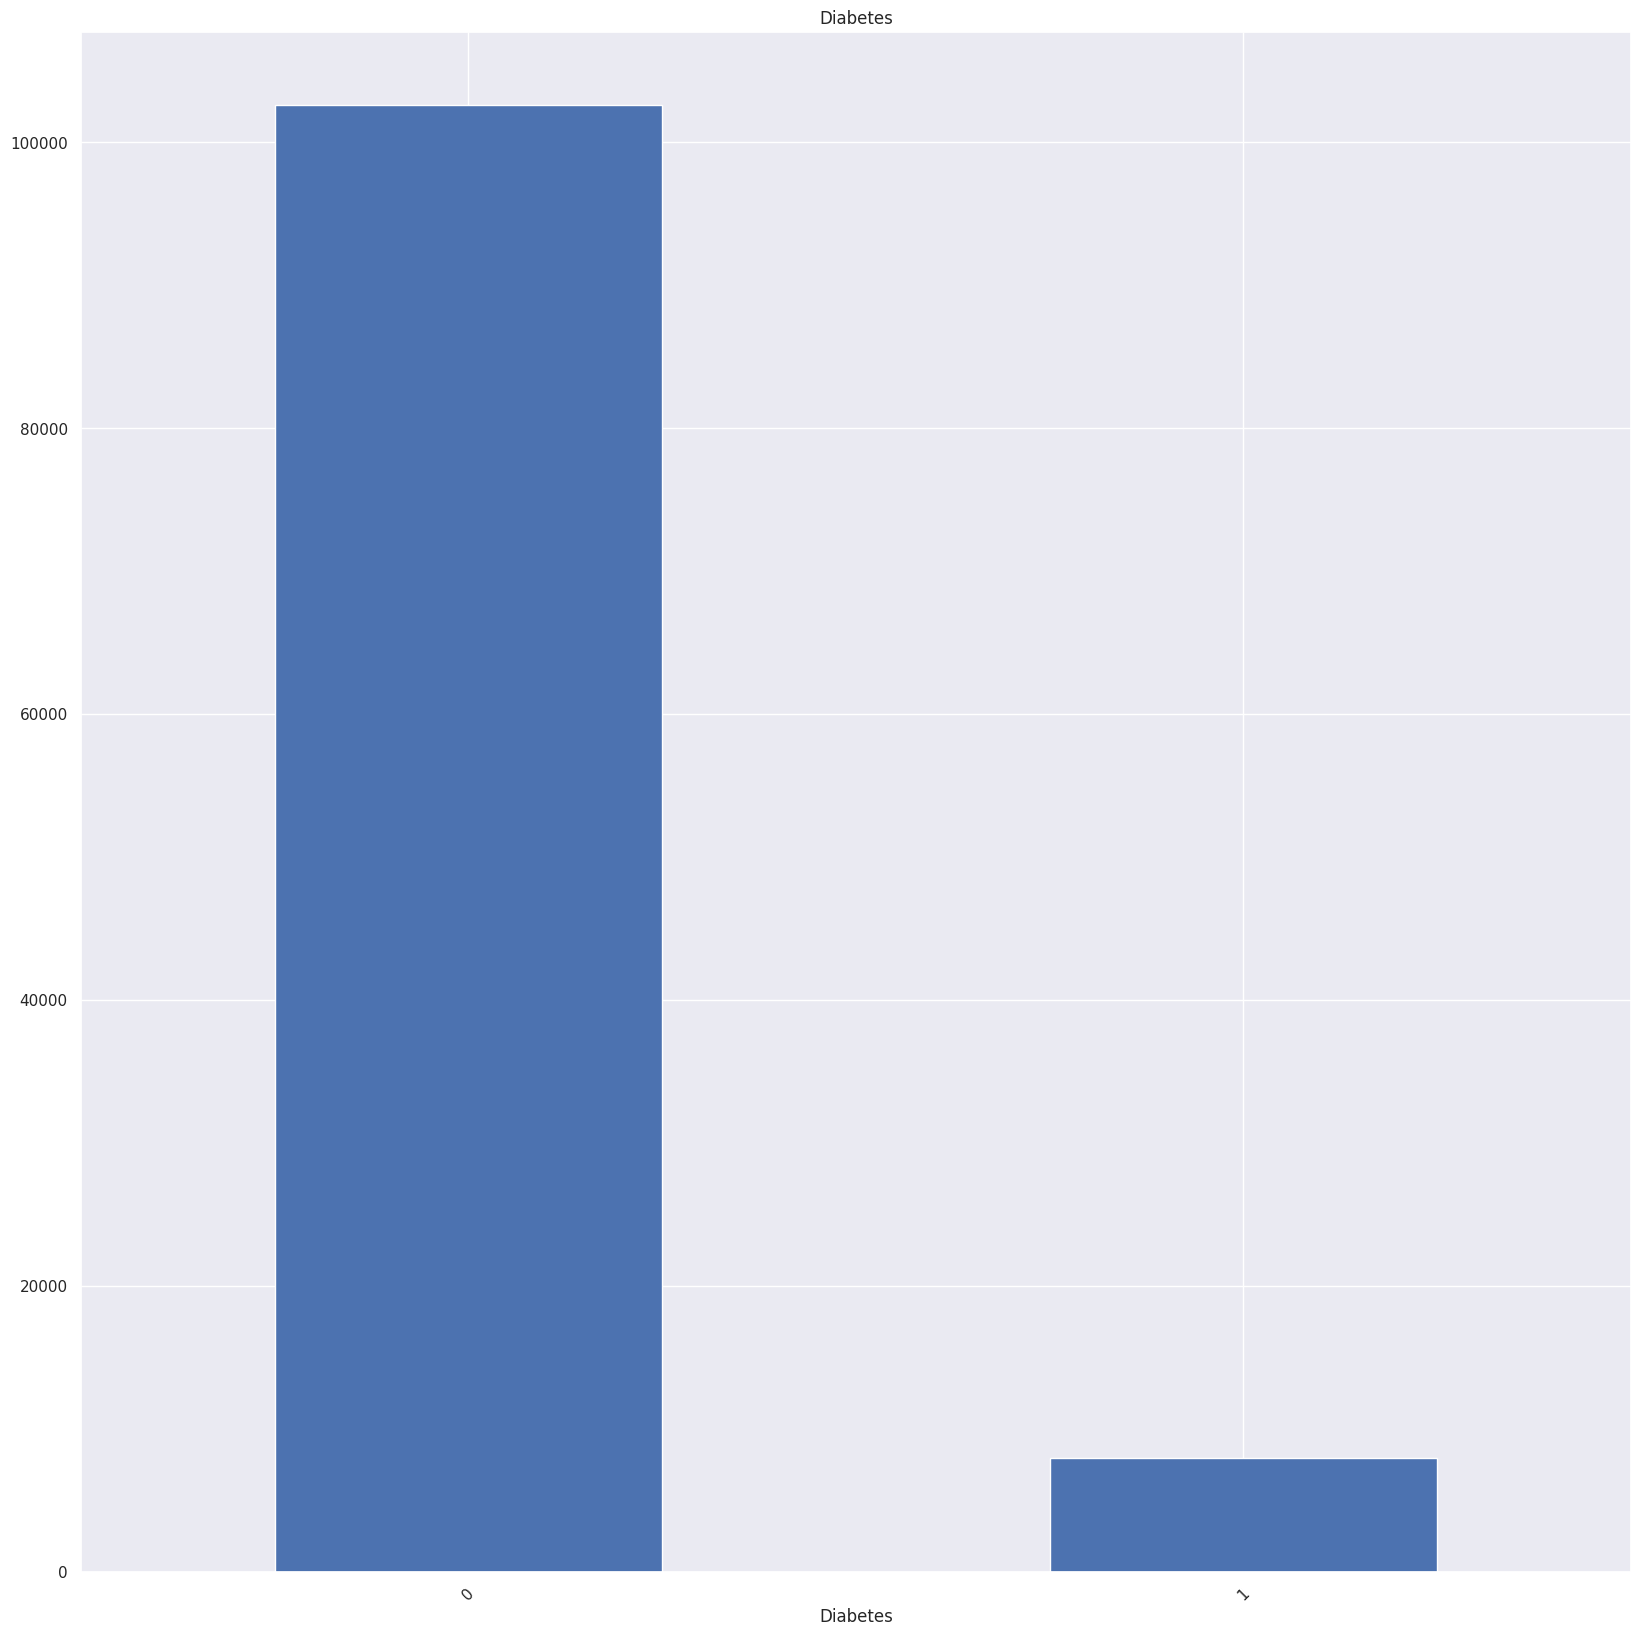

--------------------------------------------------------------------------

Column name:  Alcoholism
###########
            Alcoholism      Ratio
Alcoholism                       
0               107166  96.959991
1                 3360   3.040009


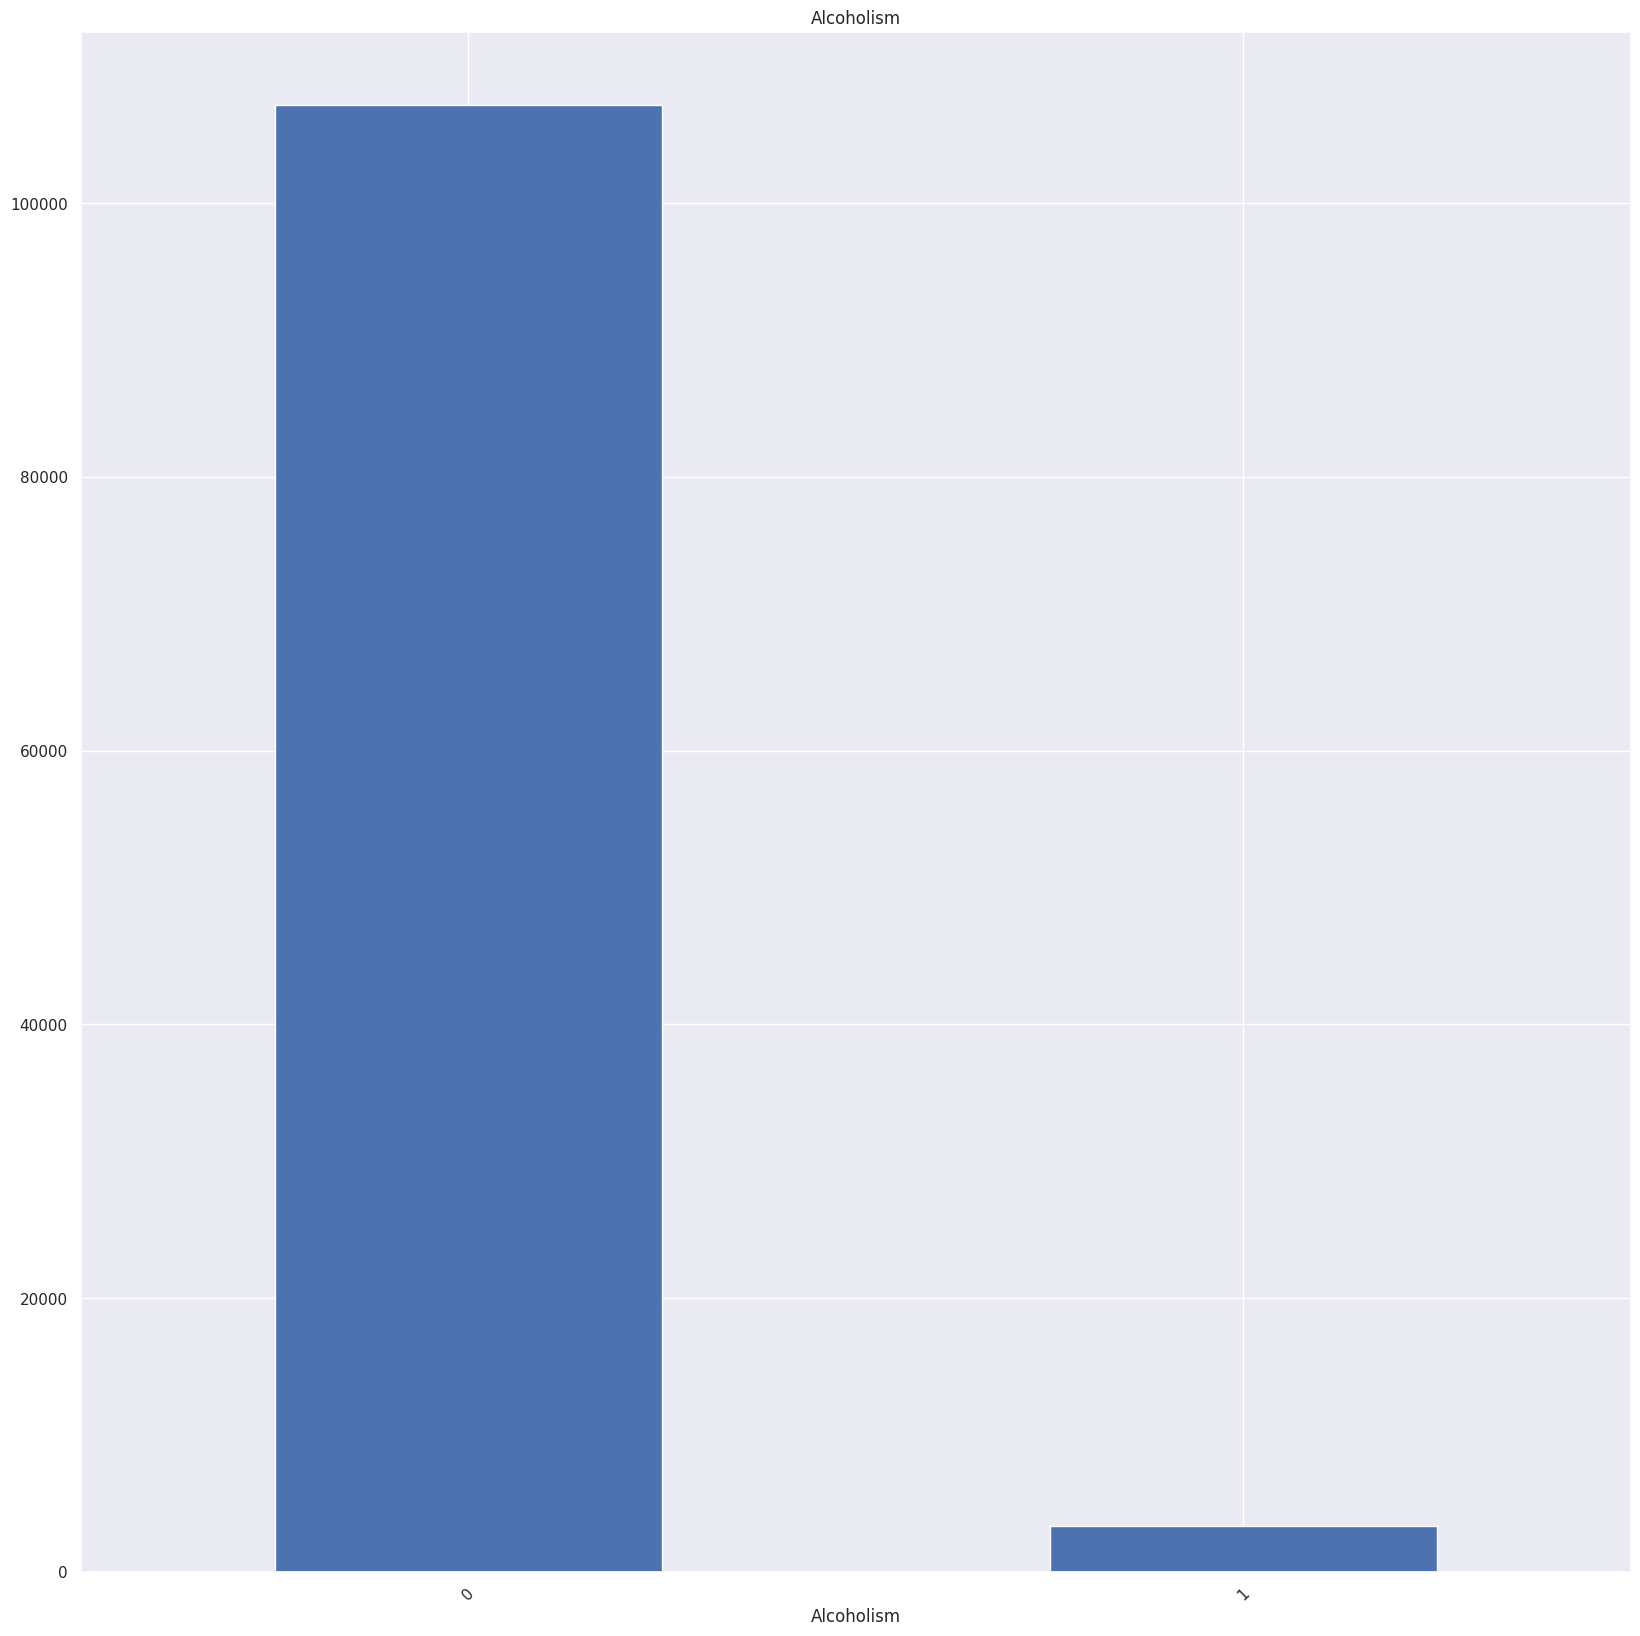

--------------------------------------------------------------------------

Column name:  Handcap
###########
         Handcap      Ratio
Handcap                    
0         108285  97.972423
1           2042   1.847529
2            183   0.165572
3             13   0.011762
4              3   0.002714


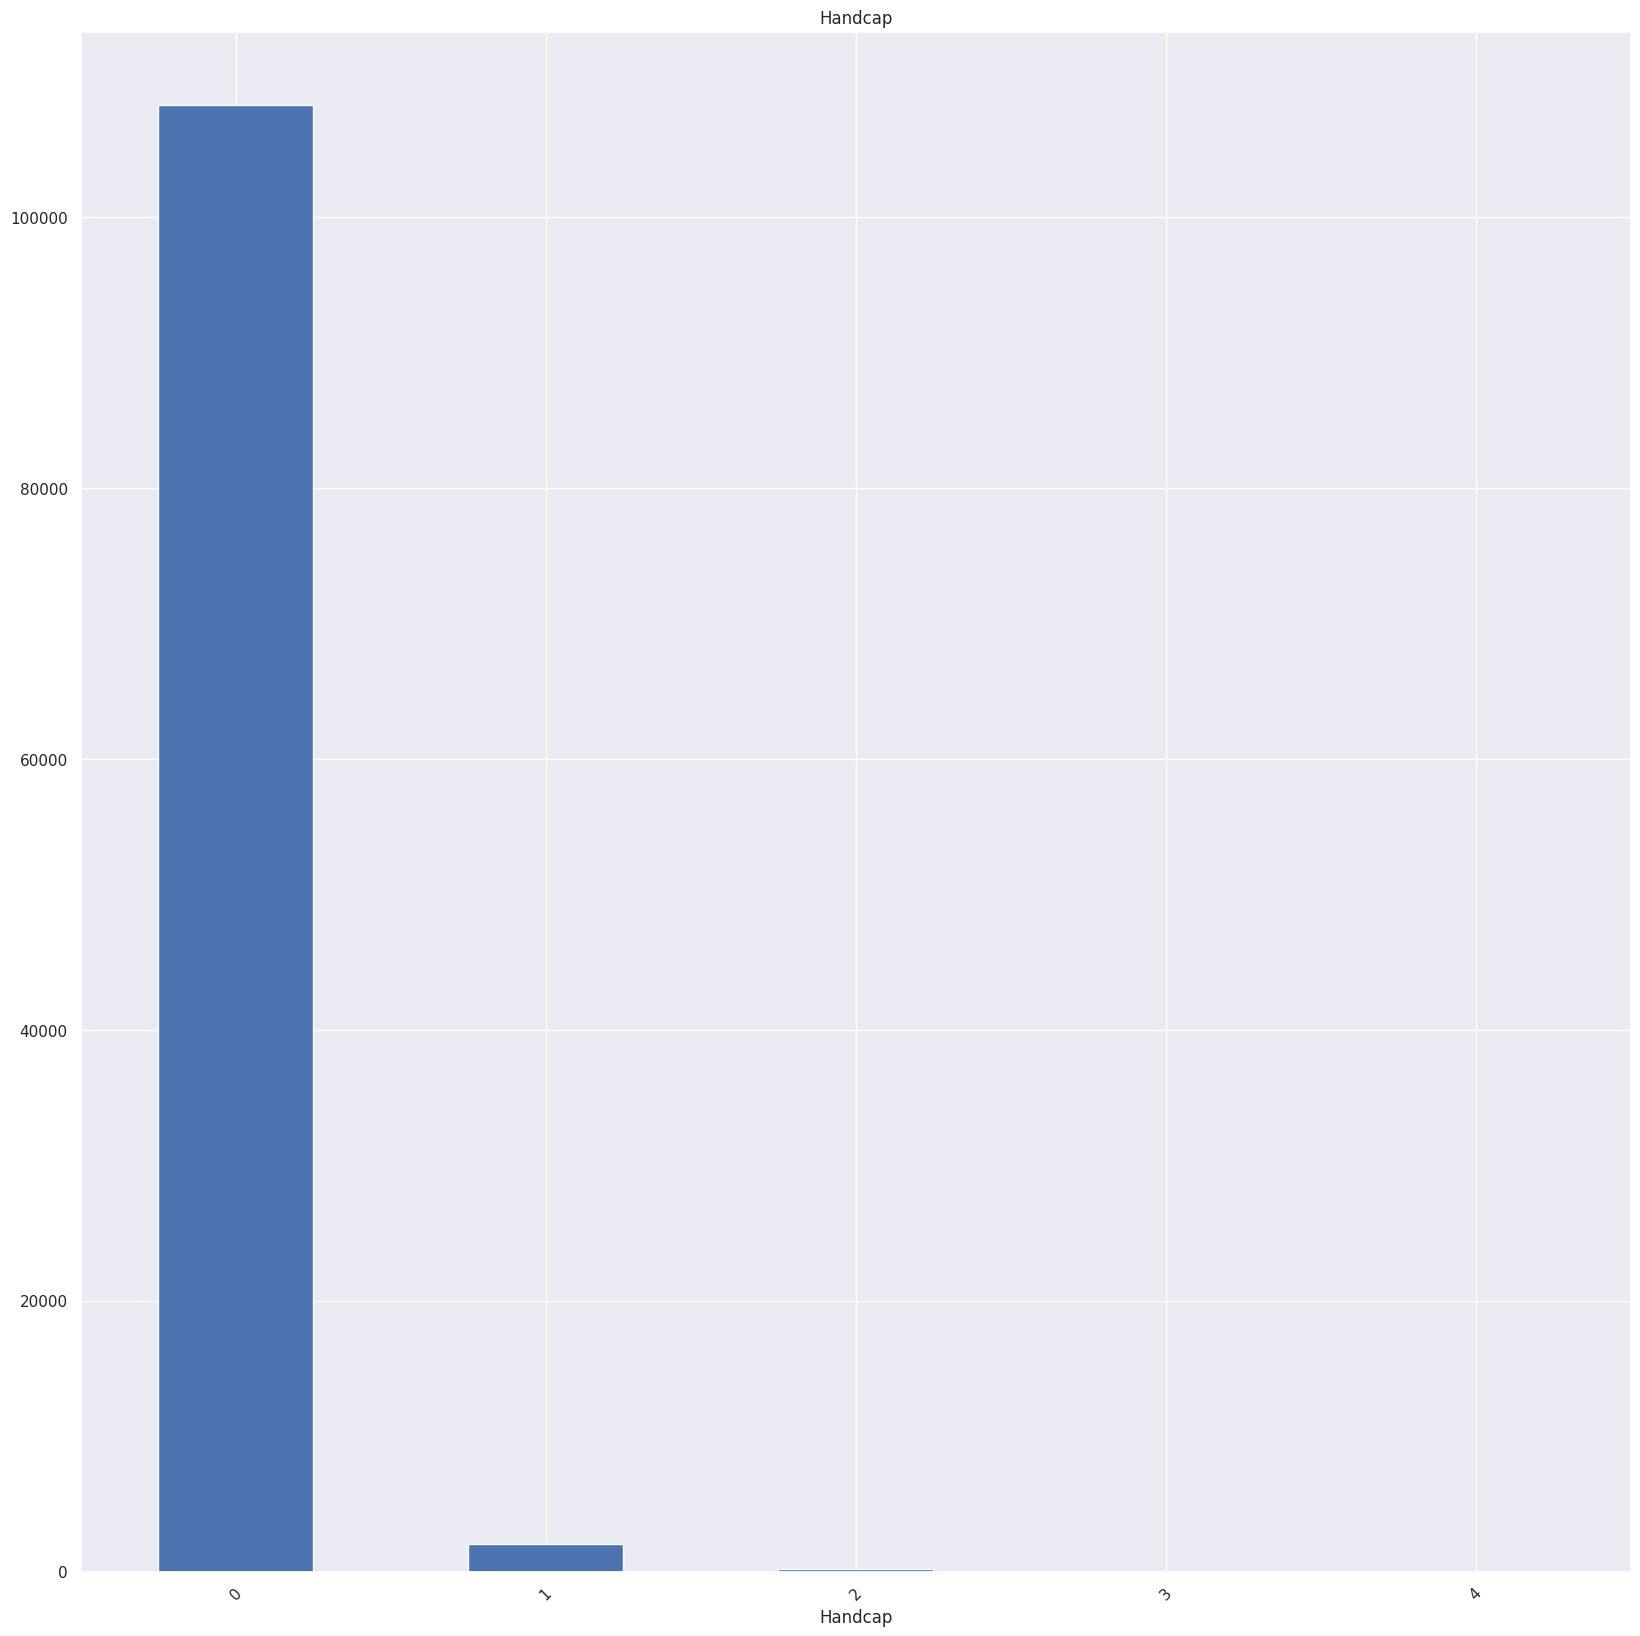

--------------------------------------------------------------------------

Column name:  SMS_received
###########
              SMS_received      Ratio
SMS_received                         
0                    75044  67.897146
1                    35482  32.102854


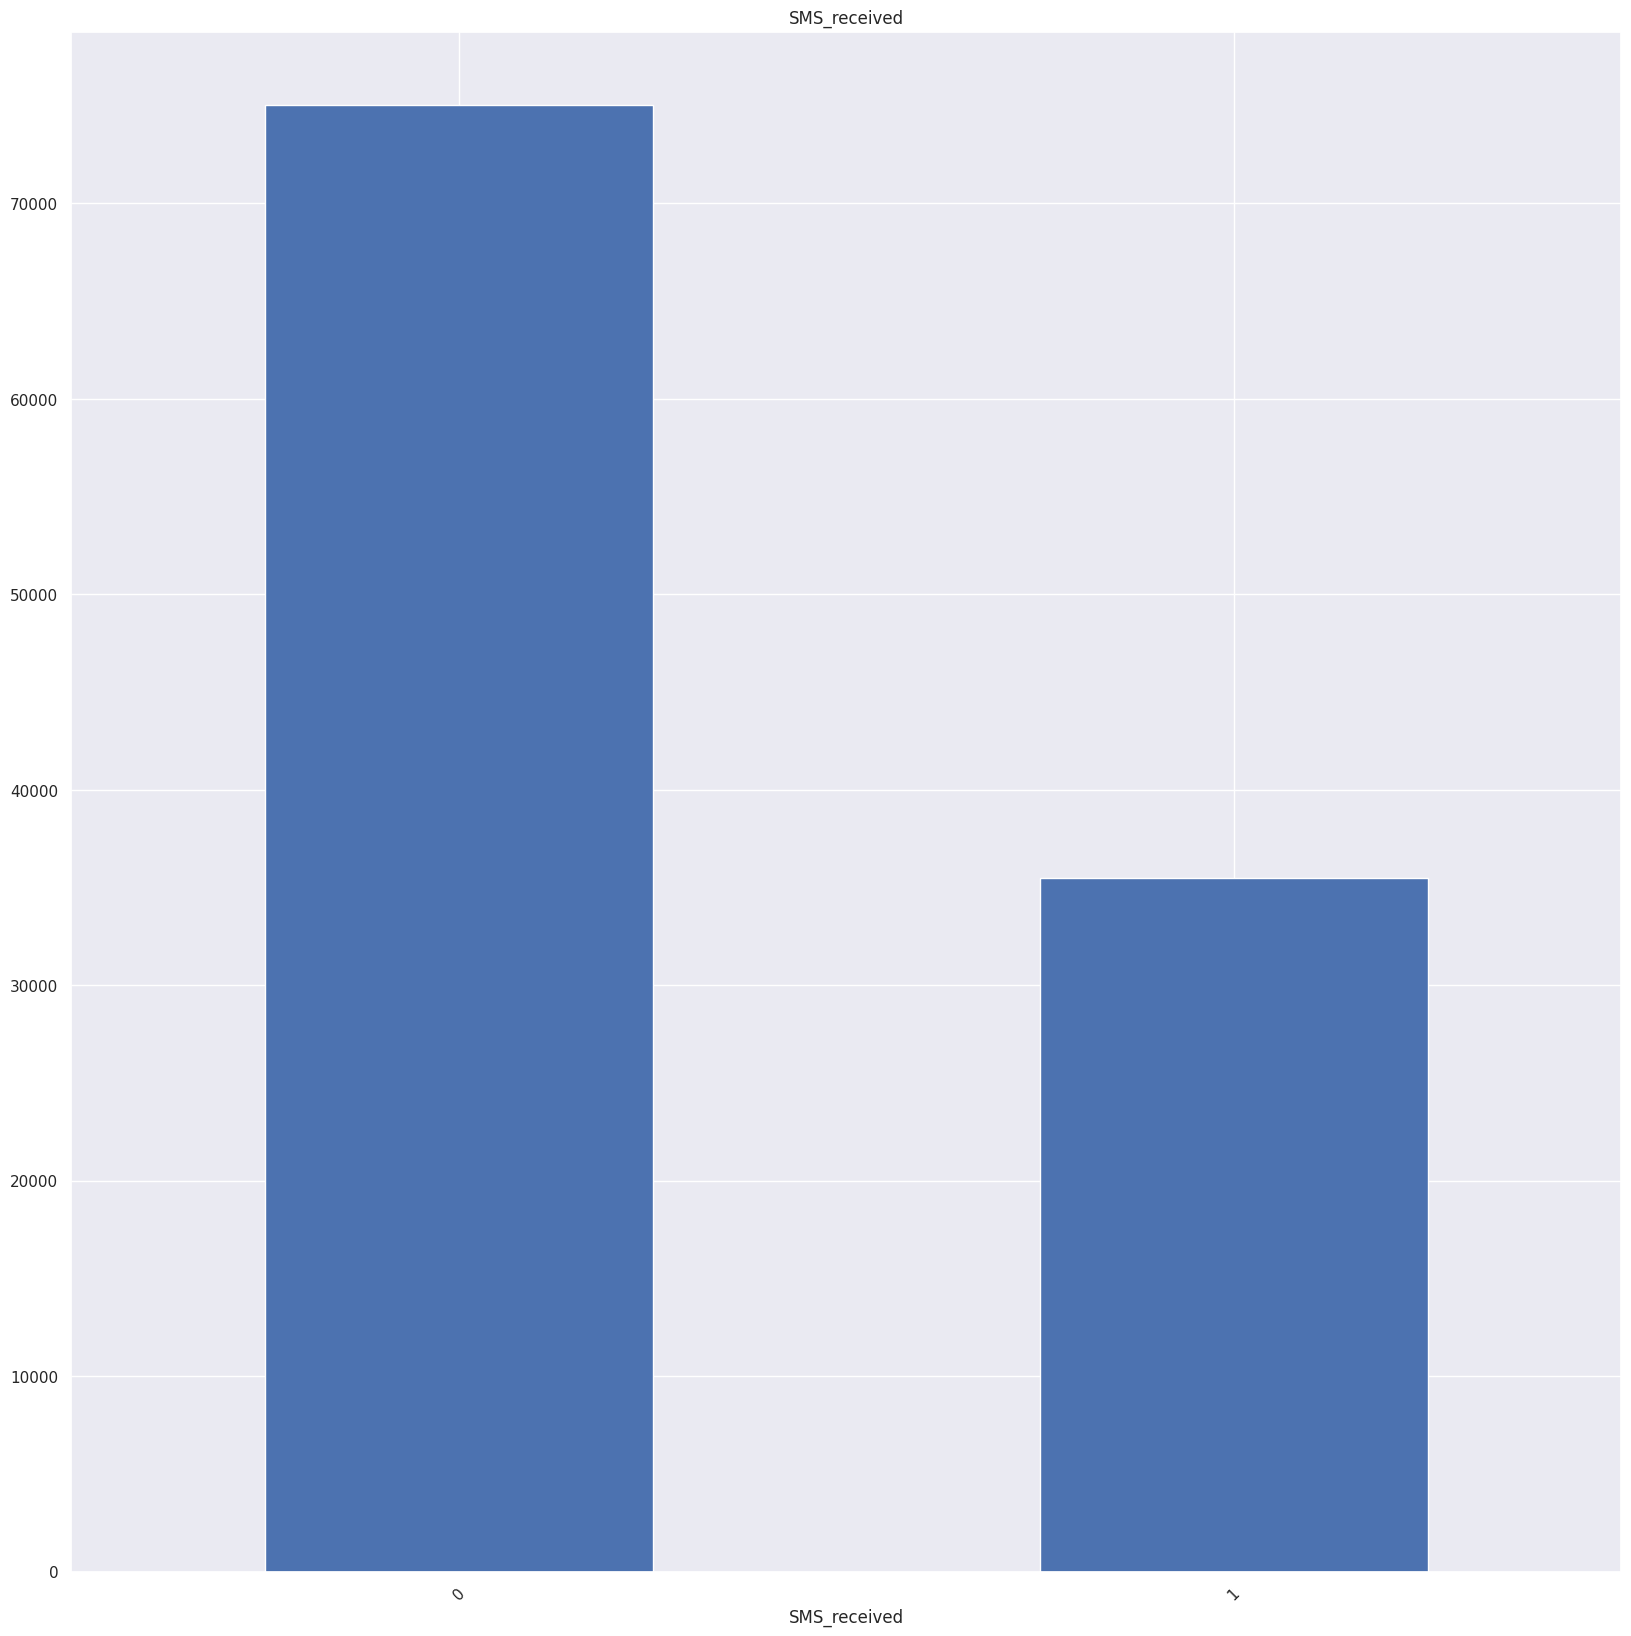

--------------------------------------------------------------------------



In [ ]:
# Categorical columns identification and visualization
def cat_summary(df, col_name):
    print(f'Column name: ', col_name)
    print("###########")
    print(pd.DataFrame({col_name: df[col_name].value_counts(),
                        "Ratio": 100 * df[col_name].value_counts() / len(df)}))

    df[col].value_counts().sort_values(ascending = False).plot(kind = "bar")
    plt.title(col)
    plt.xticks(rotation = 45)
    plt.show(block = True)
    print("--------------------------------------------------------------------------\n")

for col in cat_cols:
    cat_summary(df, col)

As can be seen in the graphs above, the distributions in the dataset are not proportional.

* The most proportional distribution is that of gender, with 60% of the dataset being female.
* For the variable handicap, the proportion of 0 is 97.9%, while the others are all quite low. Therefore, variables other than 0 can be grouped together.
* Similar to other distributions, the distribution of our target variable no-show is not proportional. While 80% of the patients turned up for the appointment, the others did not.


Gender
No-show     No    Yes
Gender               
F        57245  14594
M        30962   7725


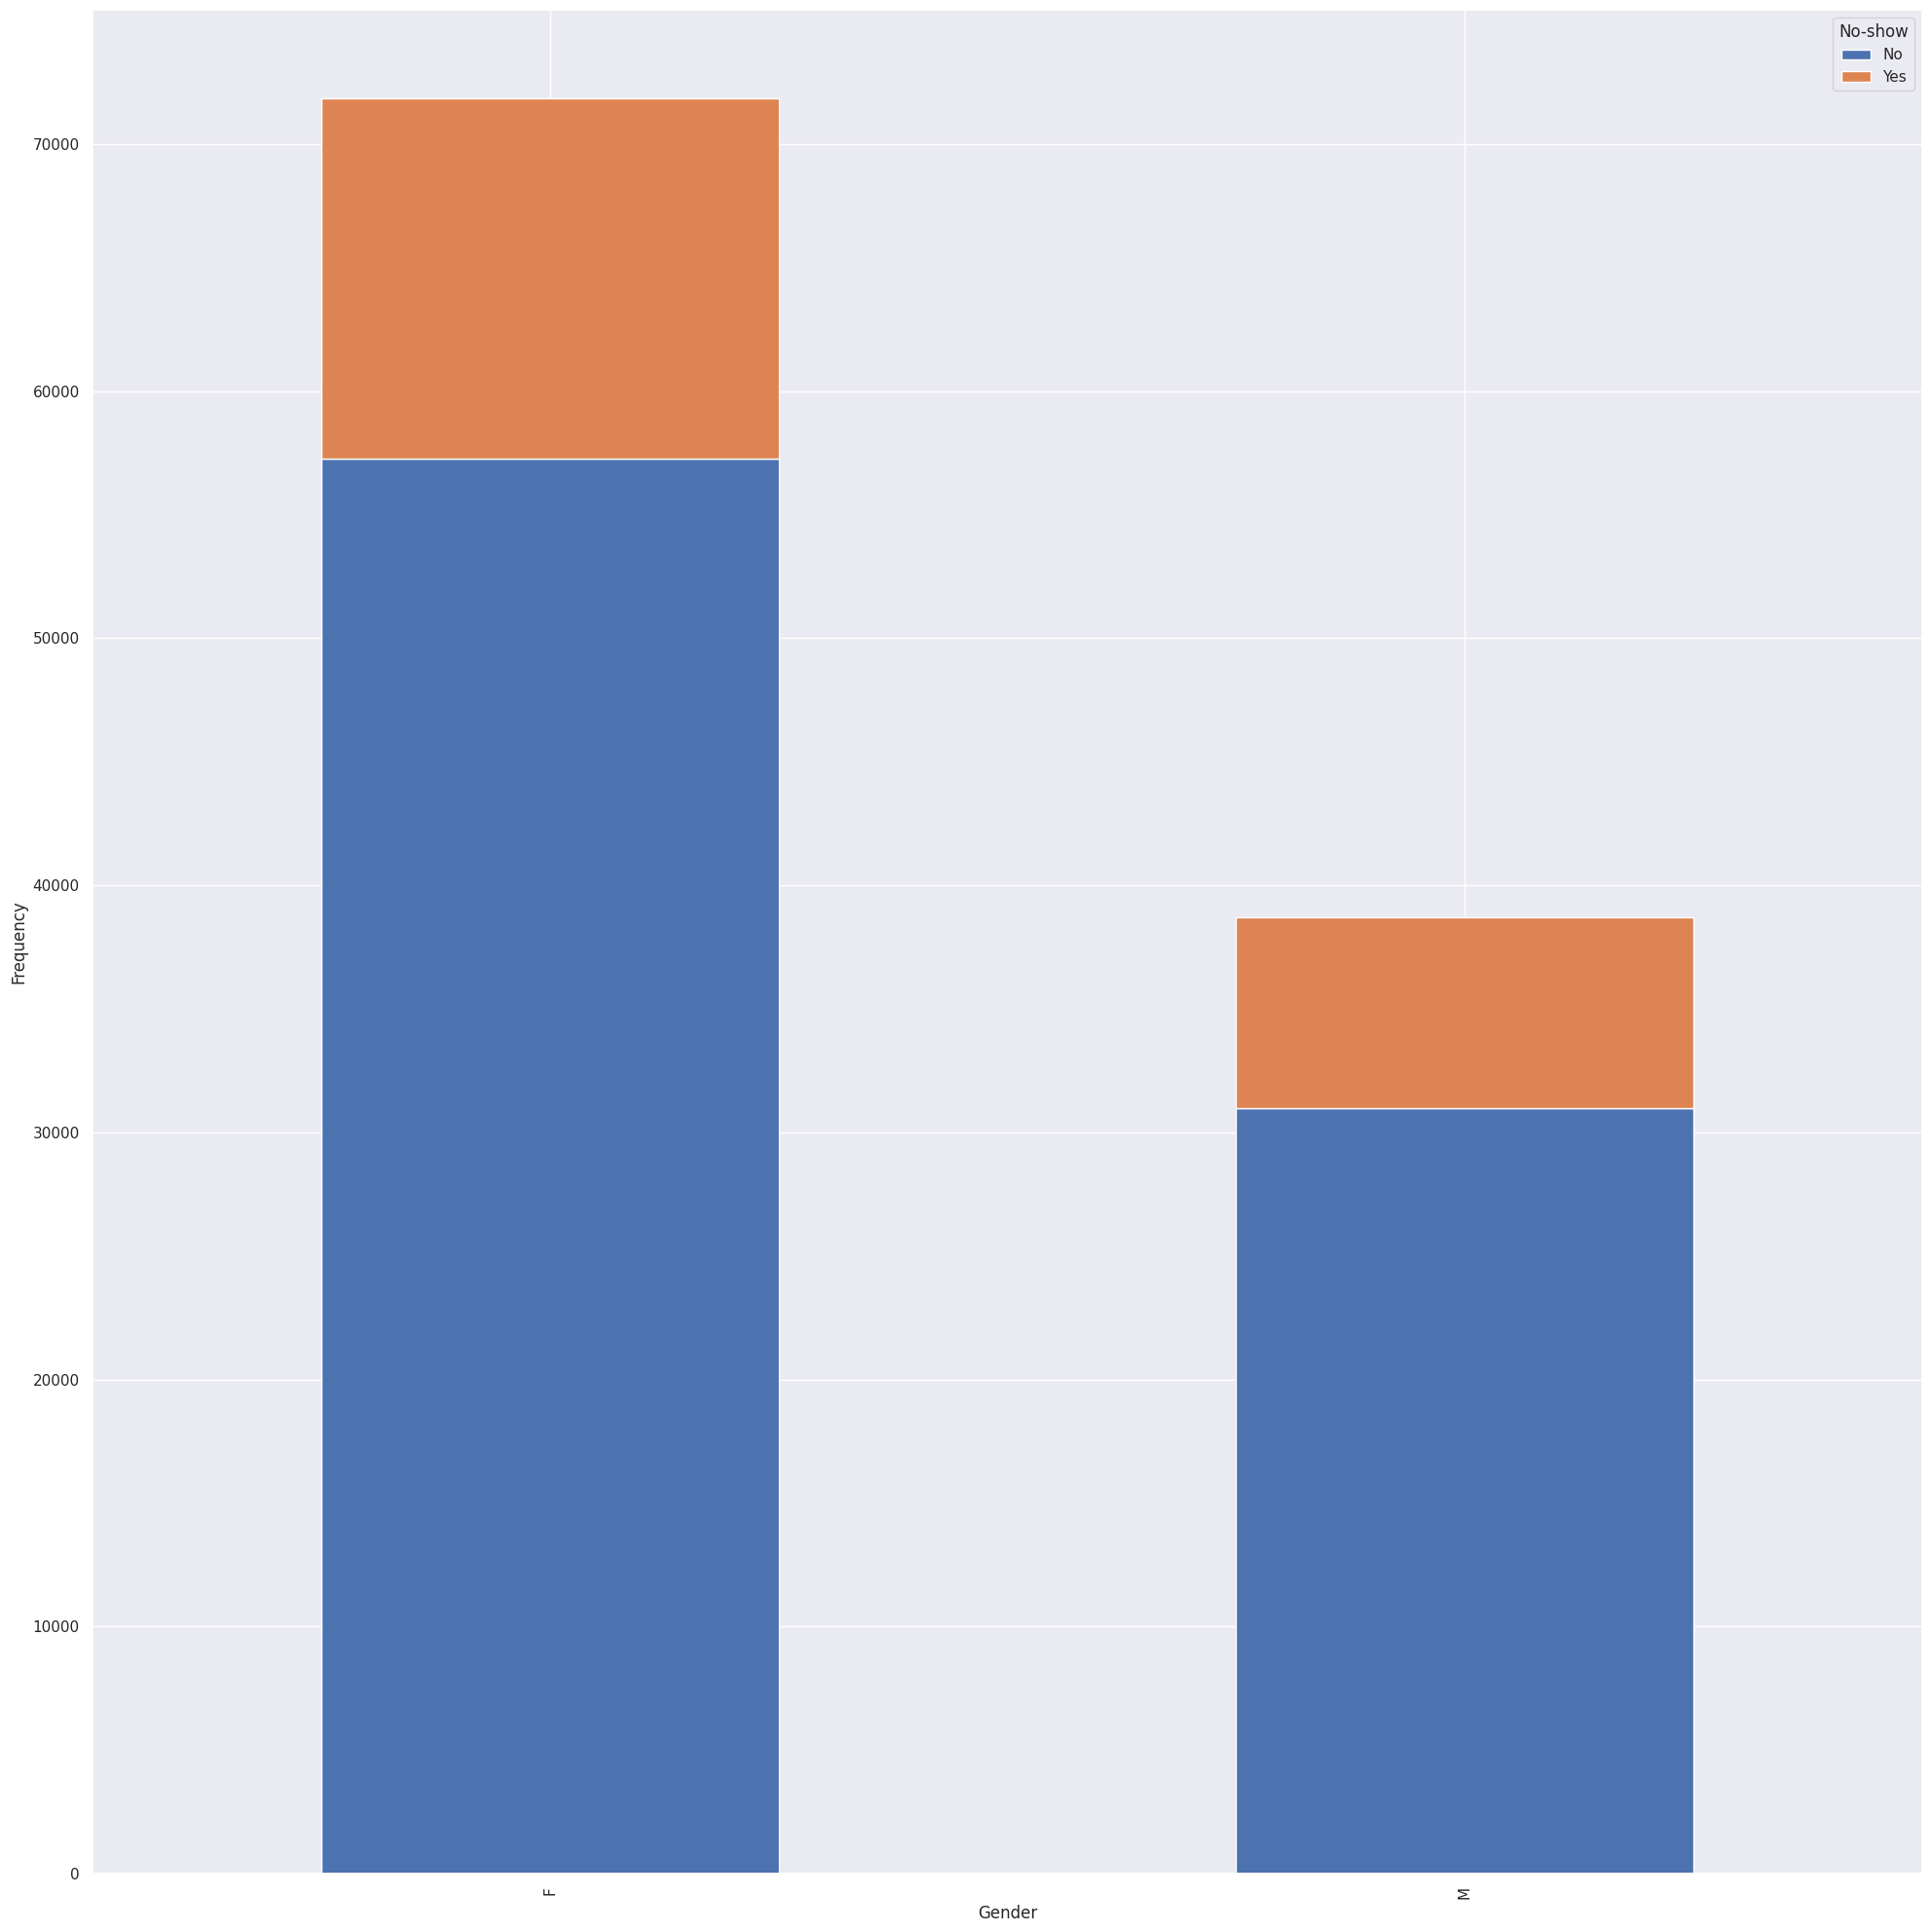

--------------------------------------------------------------------------

Neighbourhood
No-show                No  Yes
Neighbourhood                 
AEROPORTO               7    1
ANDORINHAS           1741  521
ANTÔNIO HONÓRIO       221   50
ARIOVALDO FAVALESSA   220   62
BARRO VERMELHO        332   91
...                   ...  ...
SÃO JOSÉ             1549  428
SÃO PEDRO            1933  515
TABUAZEIRO           2559  573
UNIVERSITÁRIO         120   32
VILA RUBIM            710  141

[81 rows x 2 columns]


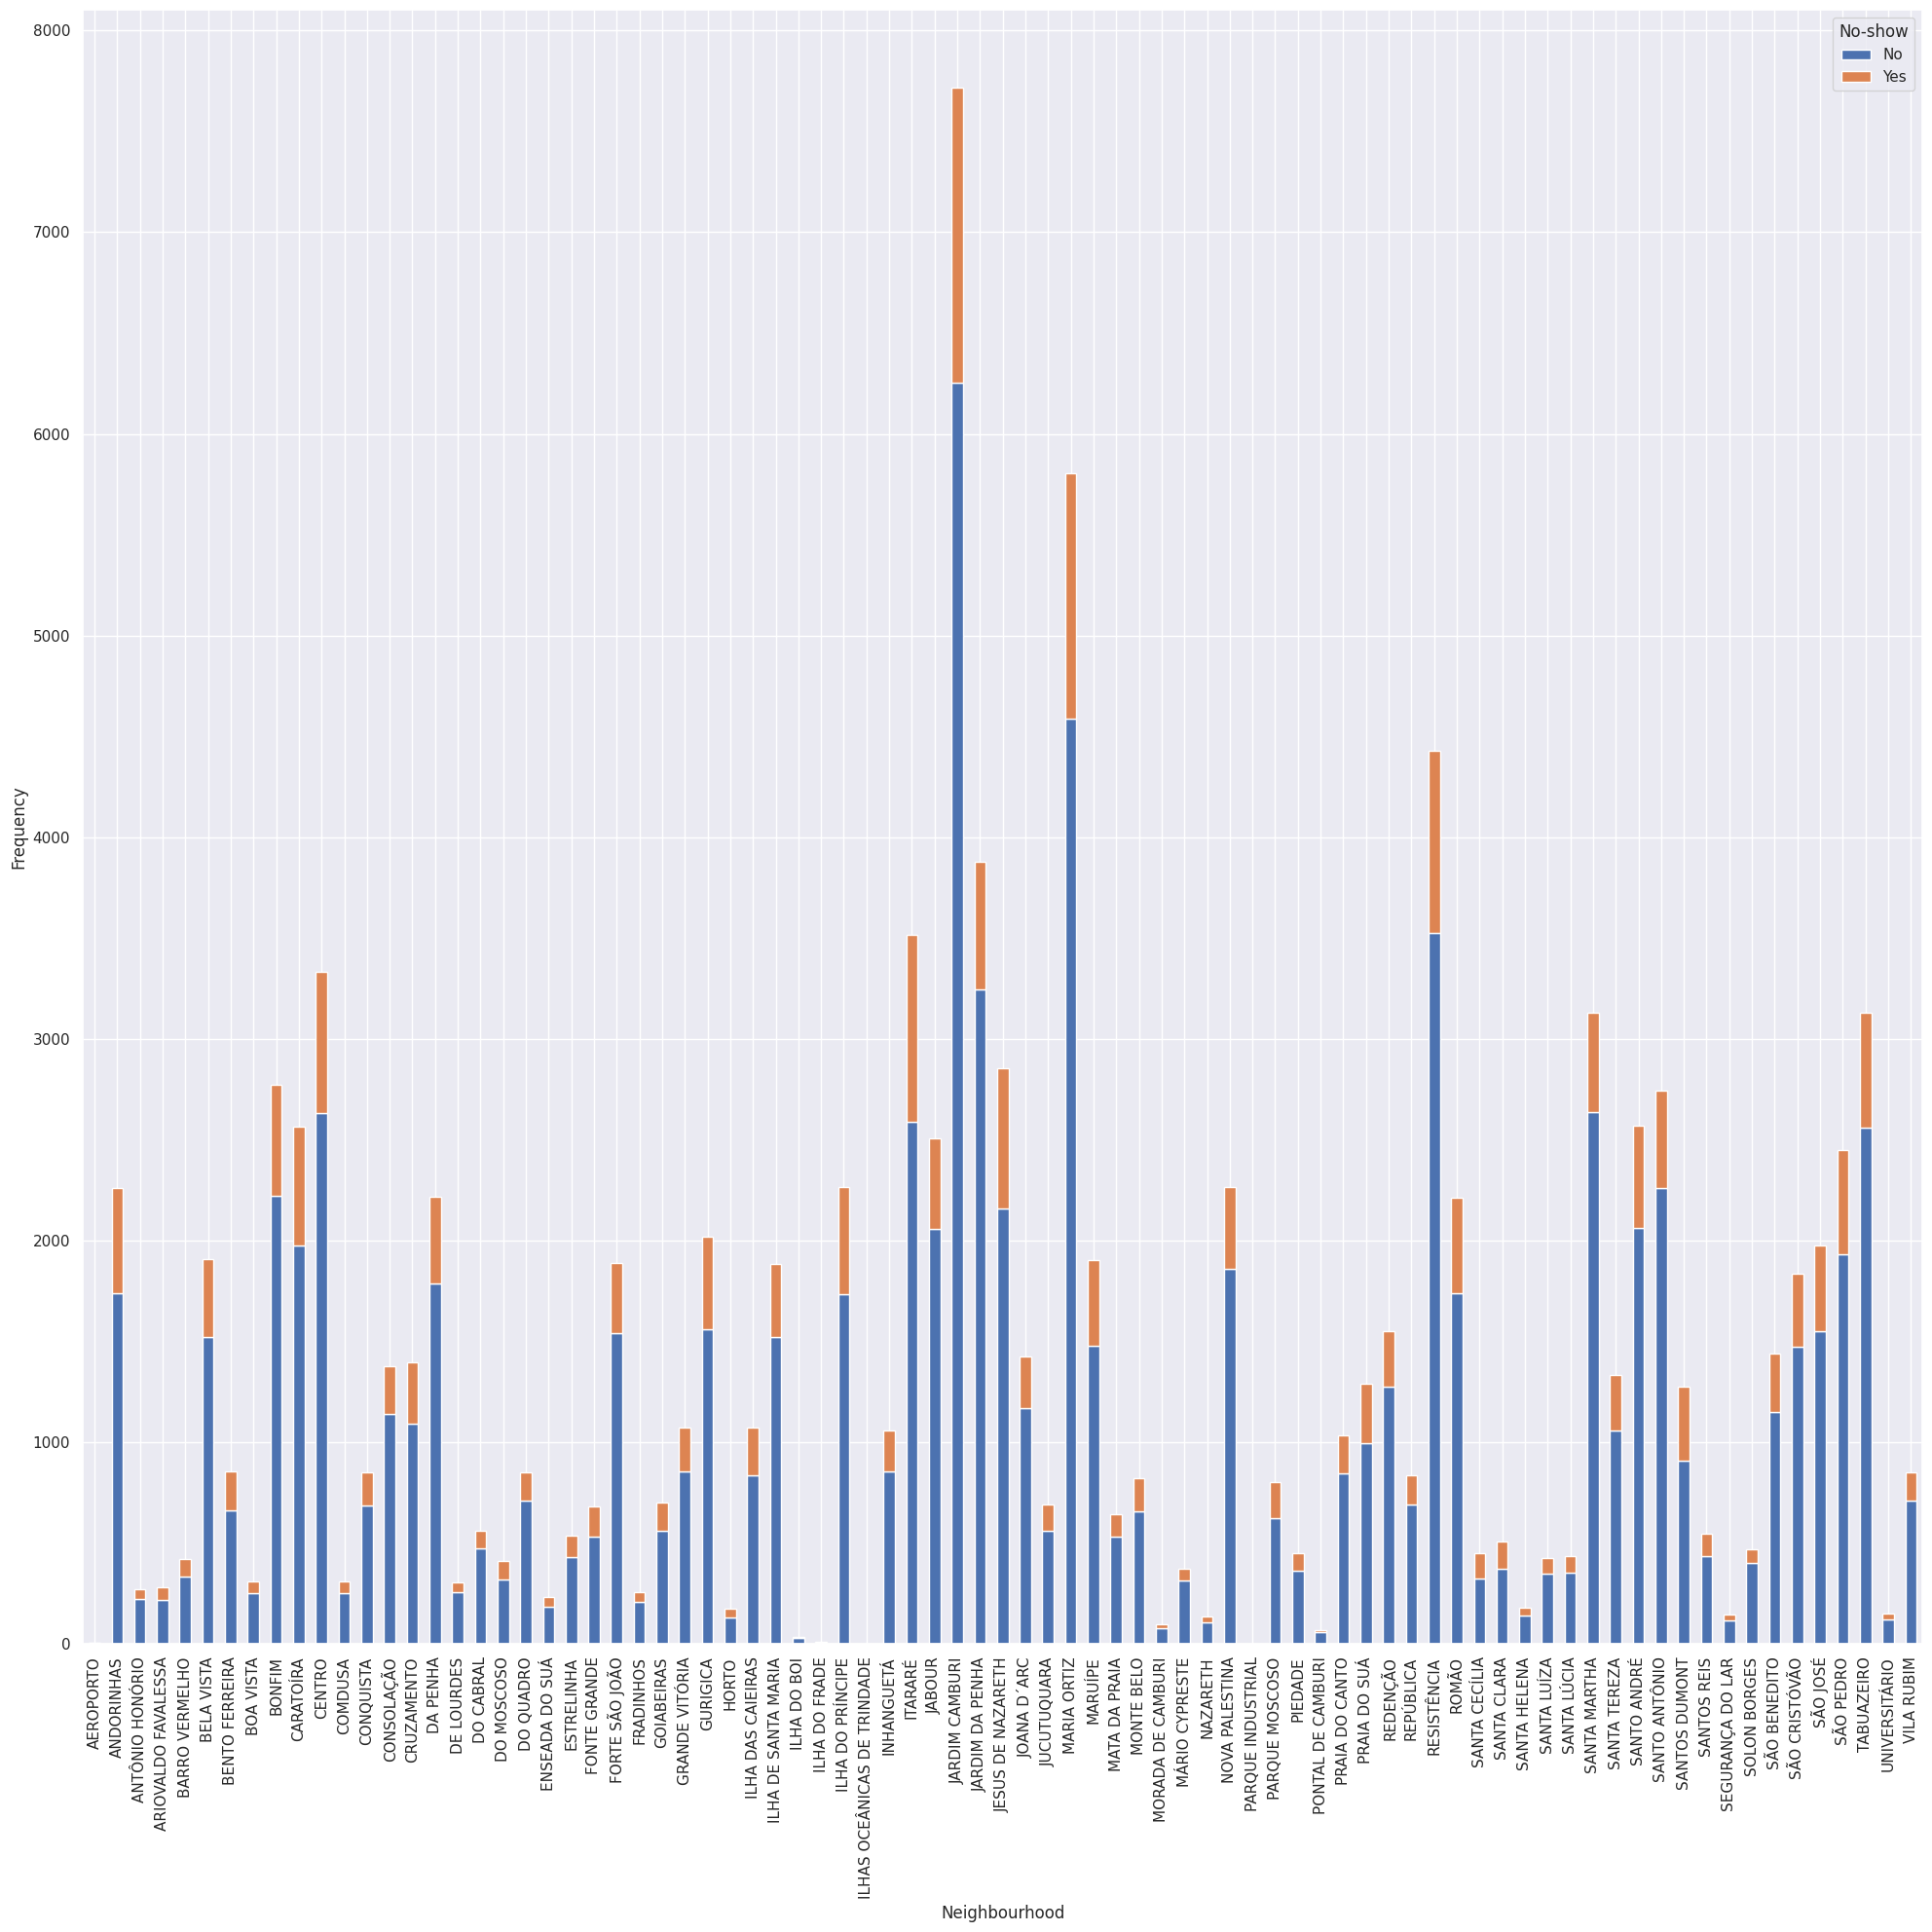

--------------------------------------------------------------------------

No-show
No-show     No    Yes
No-show              
No       88207      0
Yes          0  22319


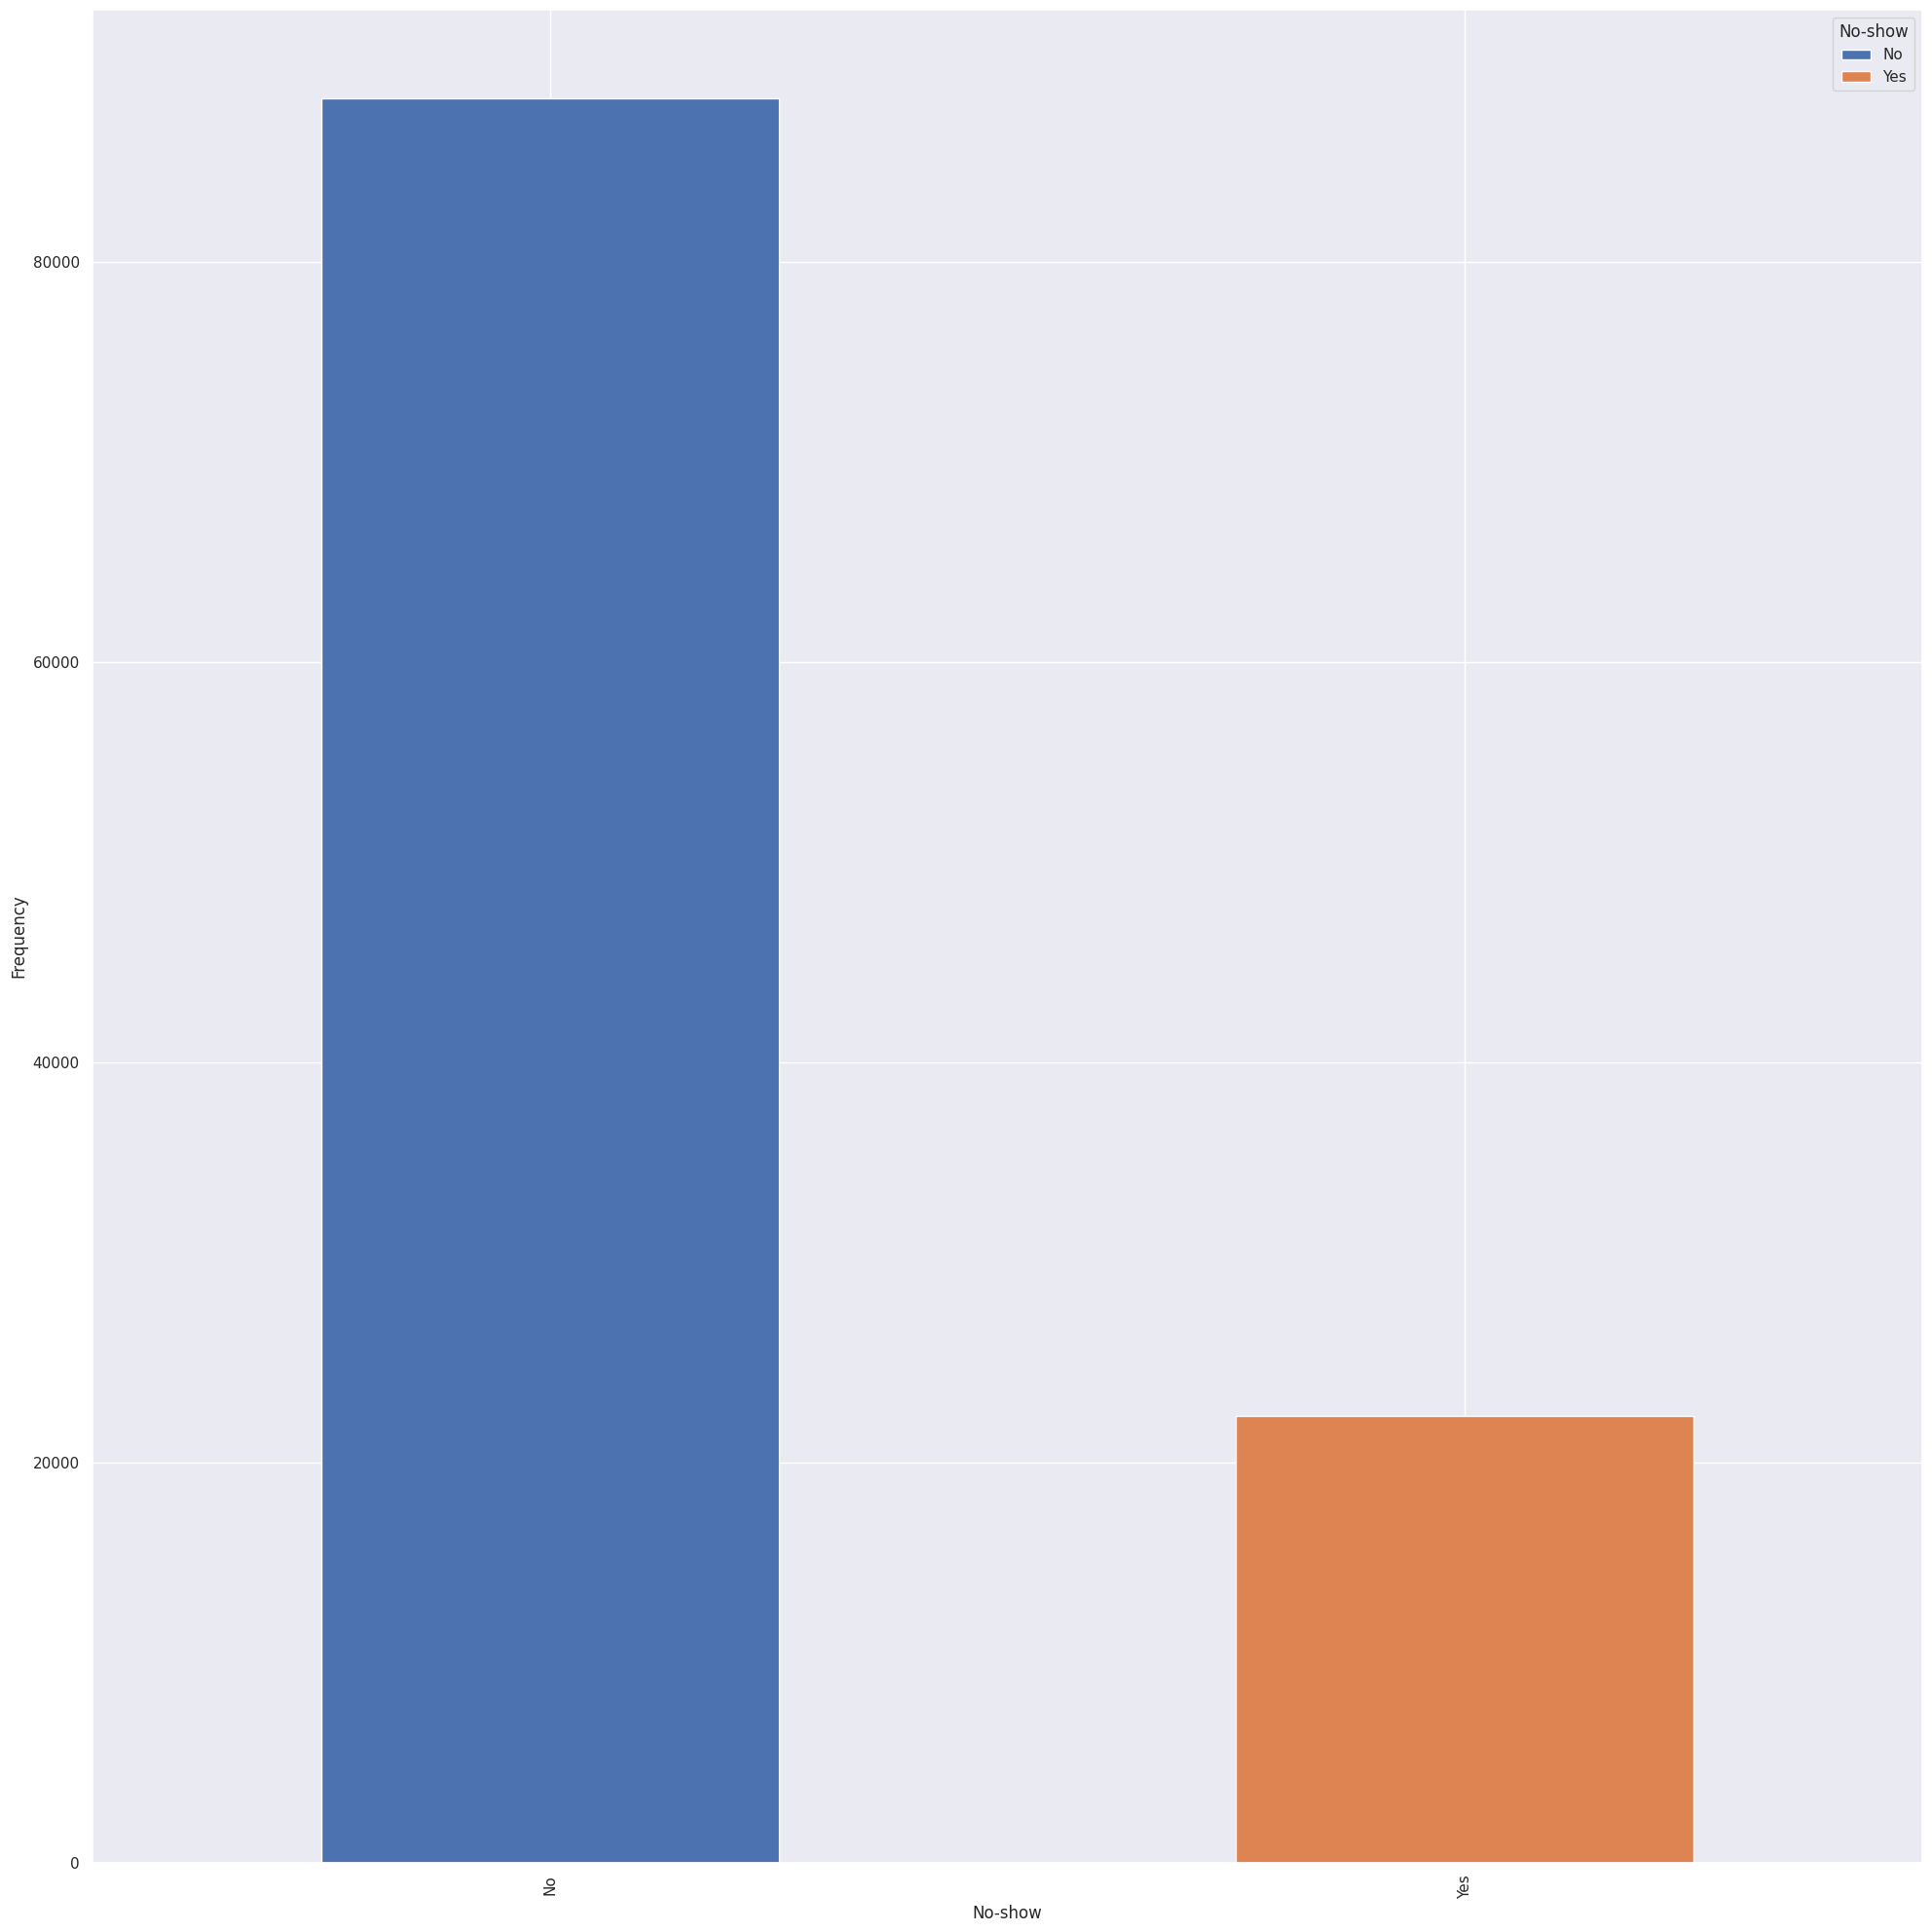

--------------------------------------------------------------------------

Scholarship
No-show         No    Yes
Scholarship              
0            79924  19741
1             8283   2578


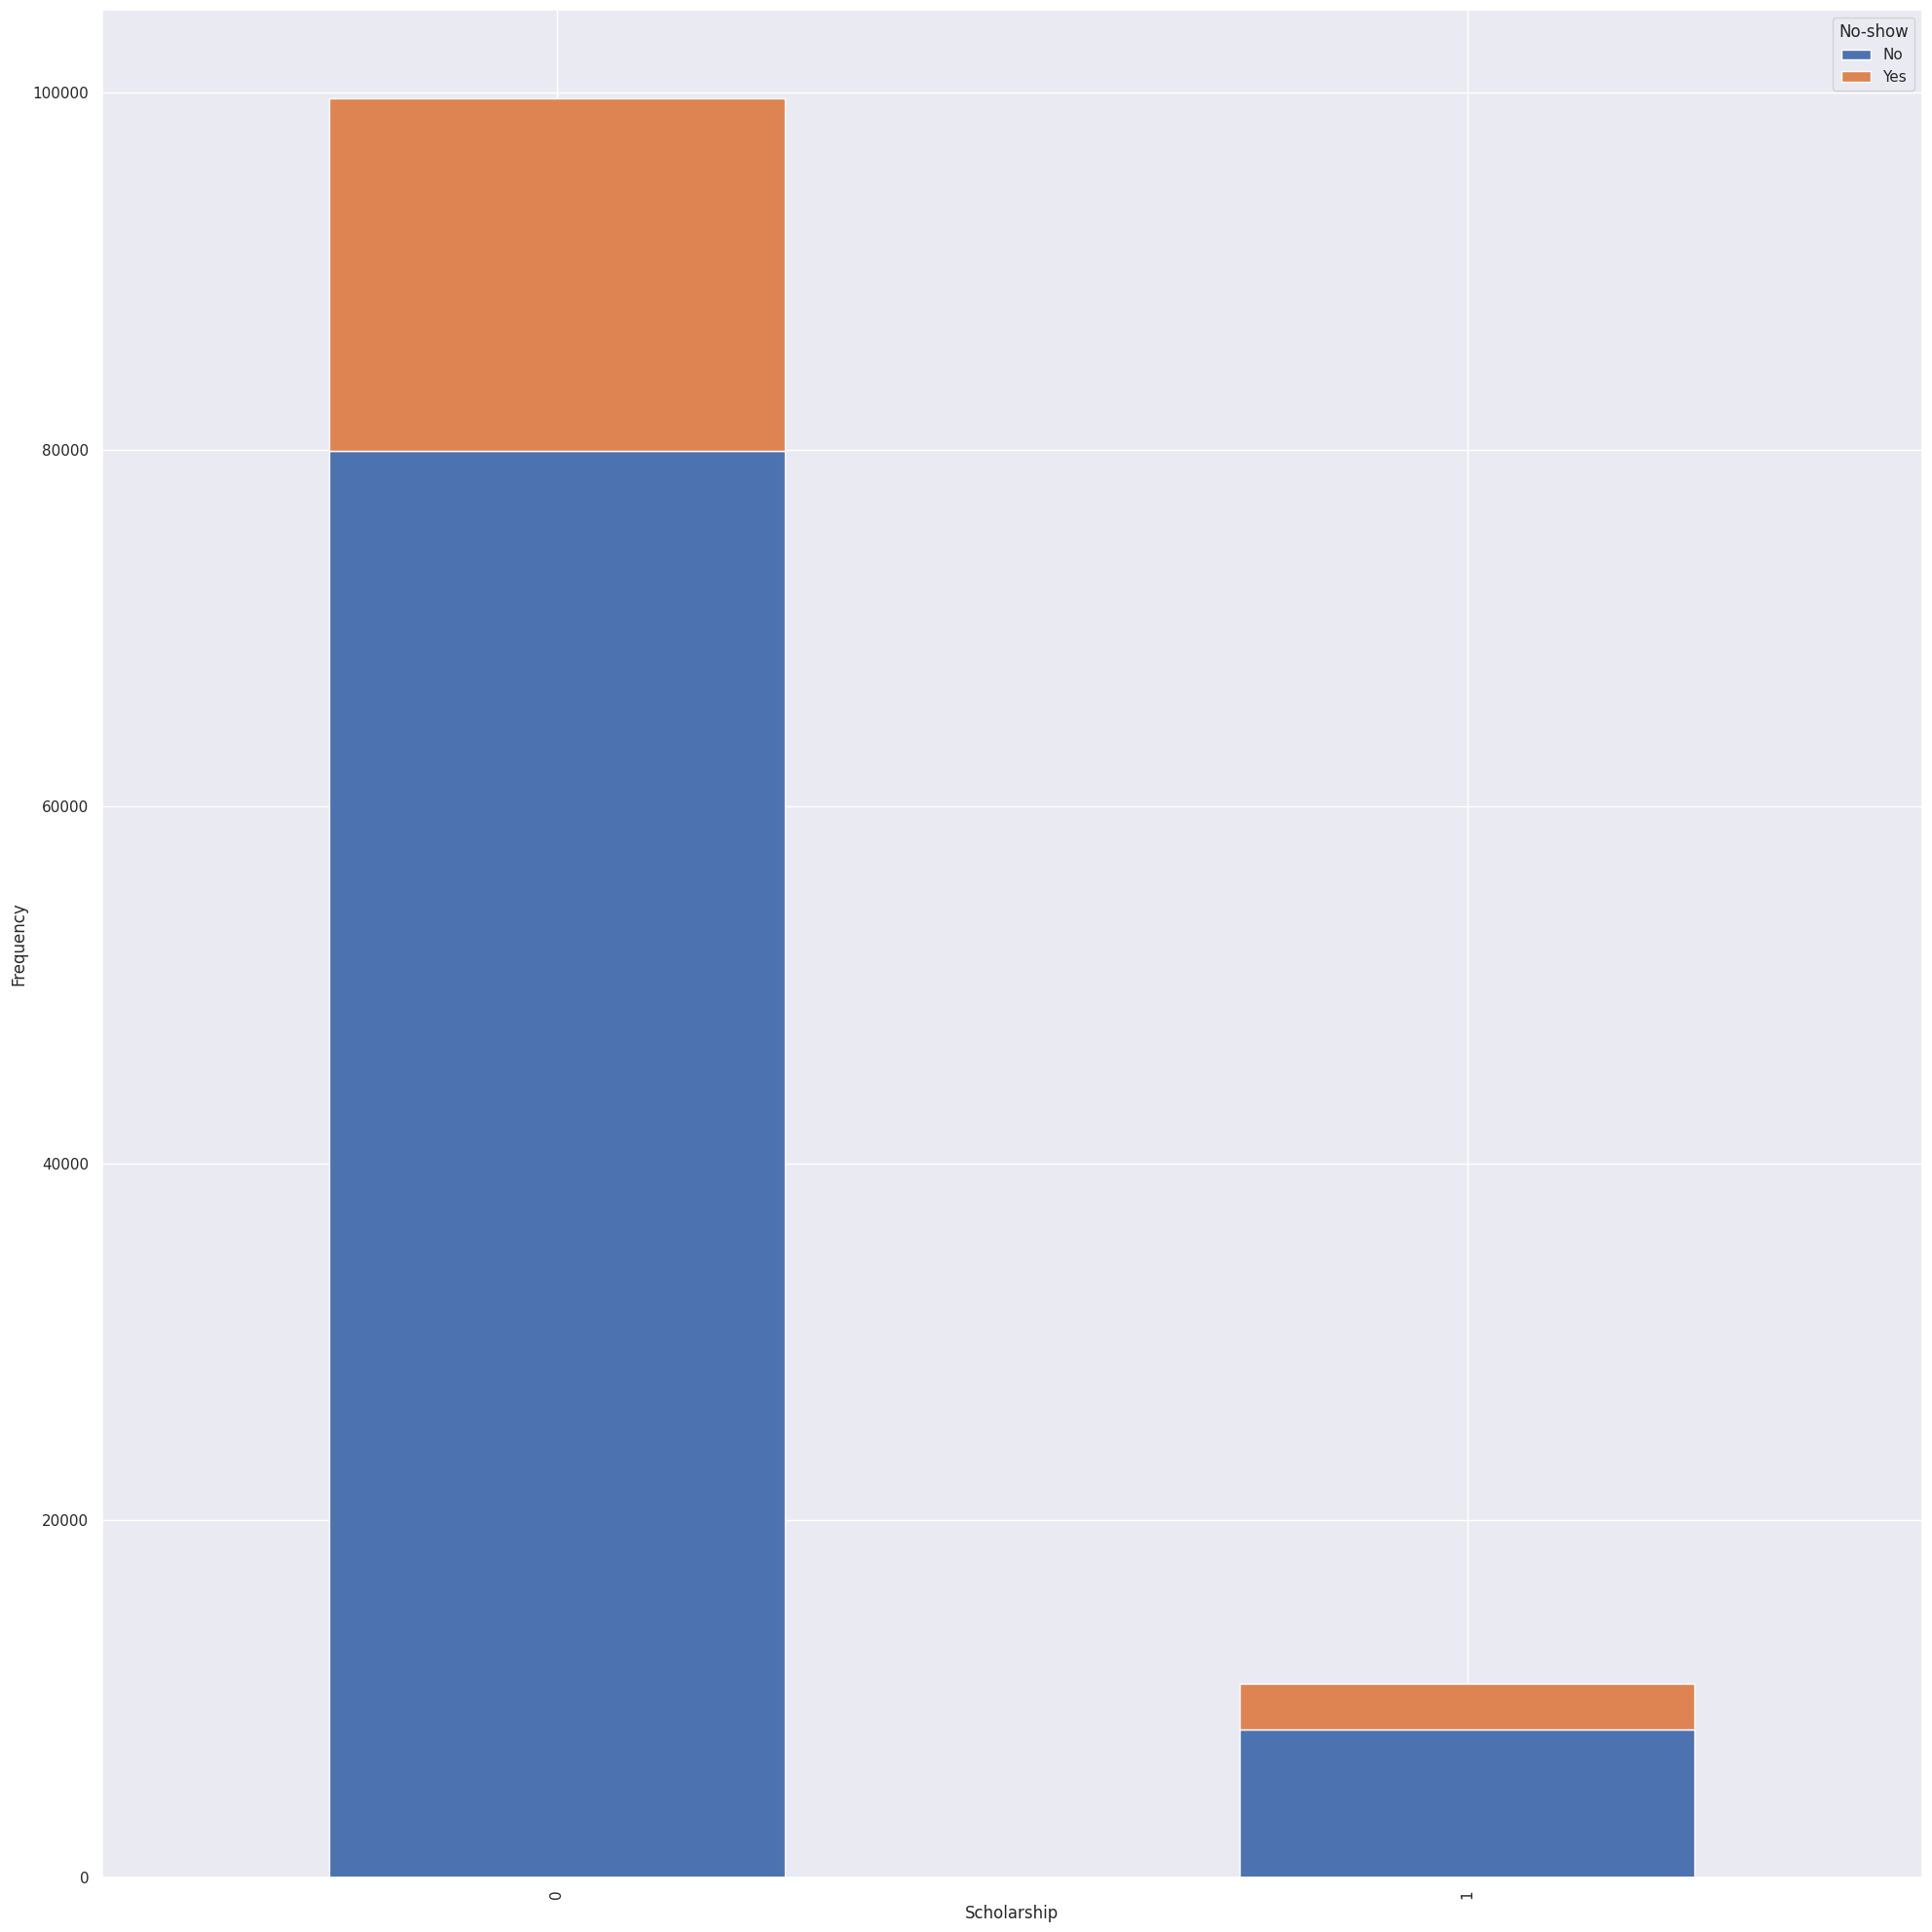

--------------------------------------------------------------------------

Hipertension
No-show          No    Yes
Hipertension              
0             70178  18547
1             18029   3772


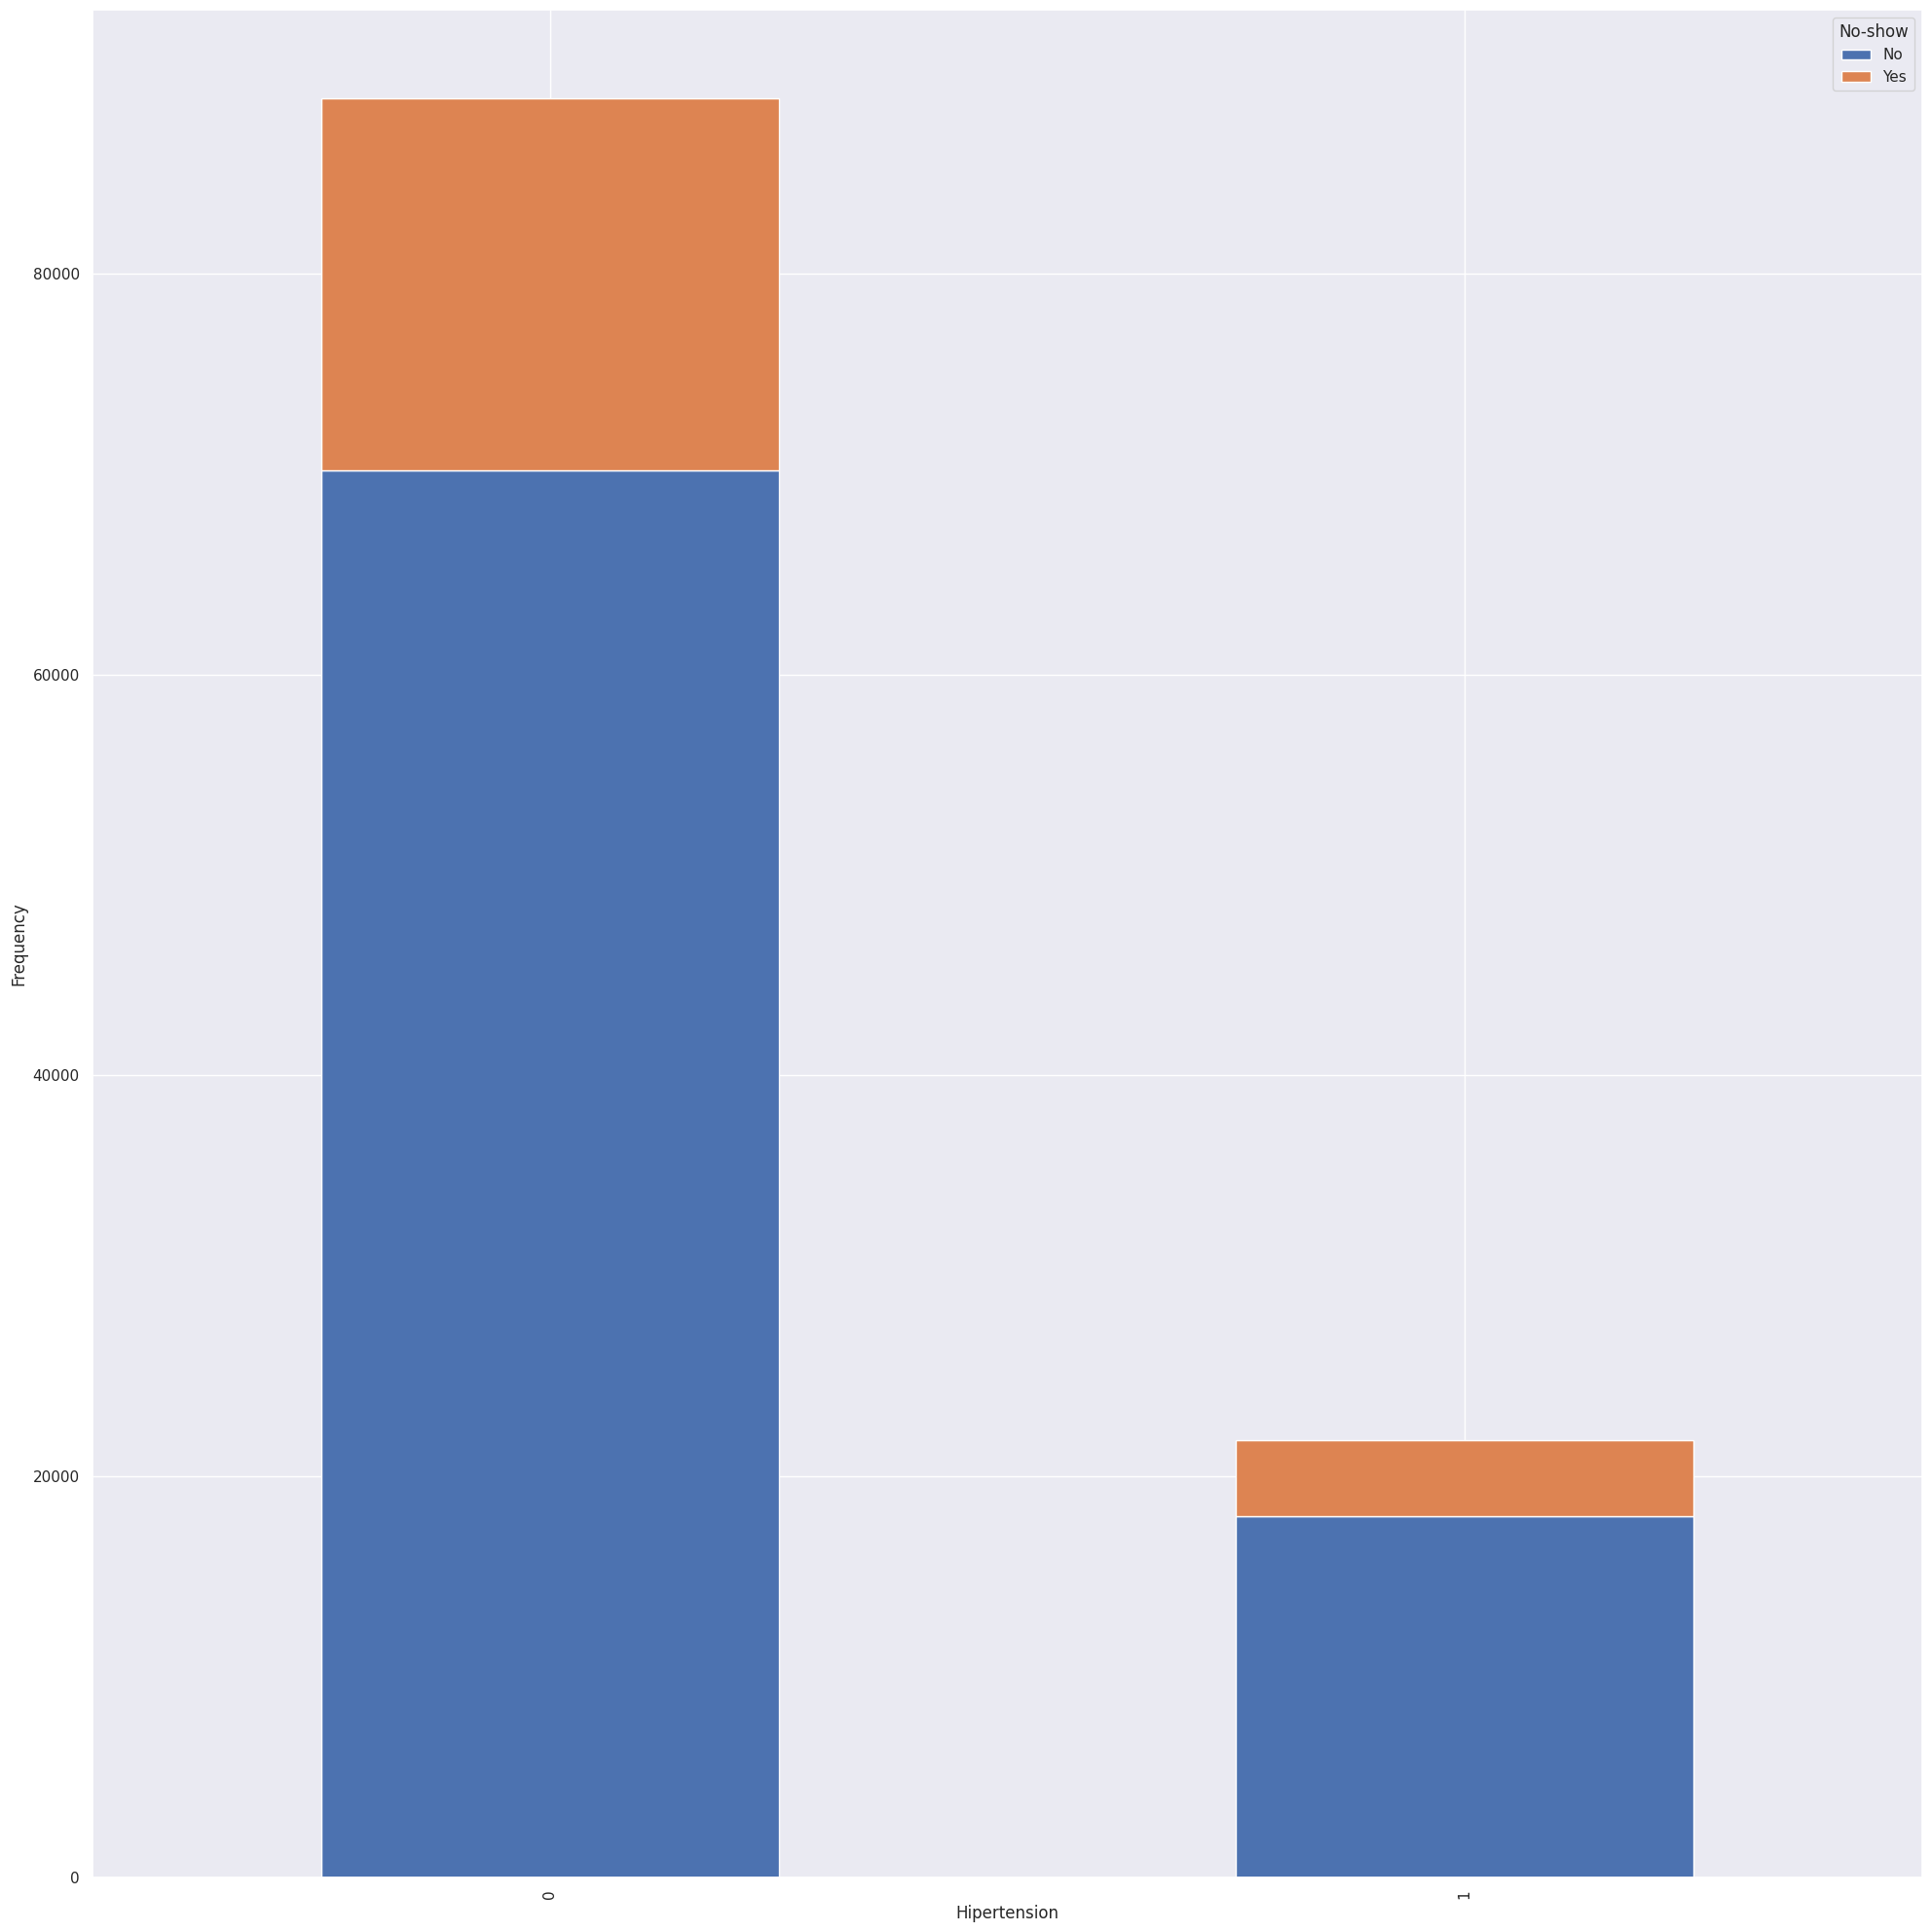

--------------------------------------------------------------------------

Diabetes
No-show      No    Yes
Diabetes              
0         81694  20889
1          6513   1430


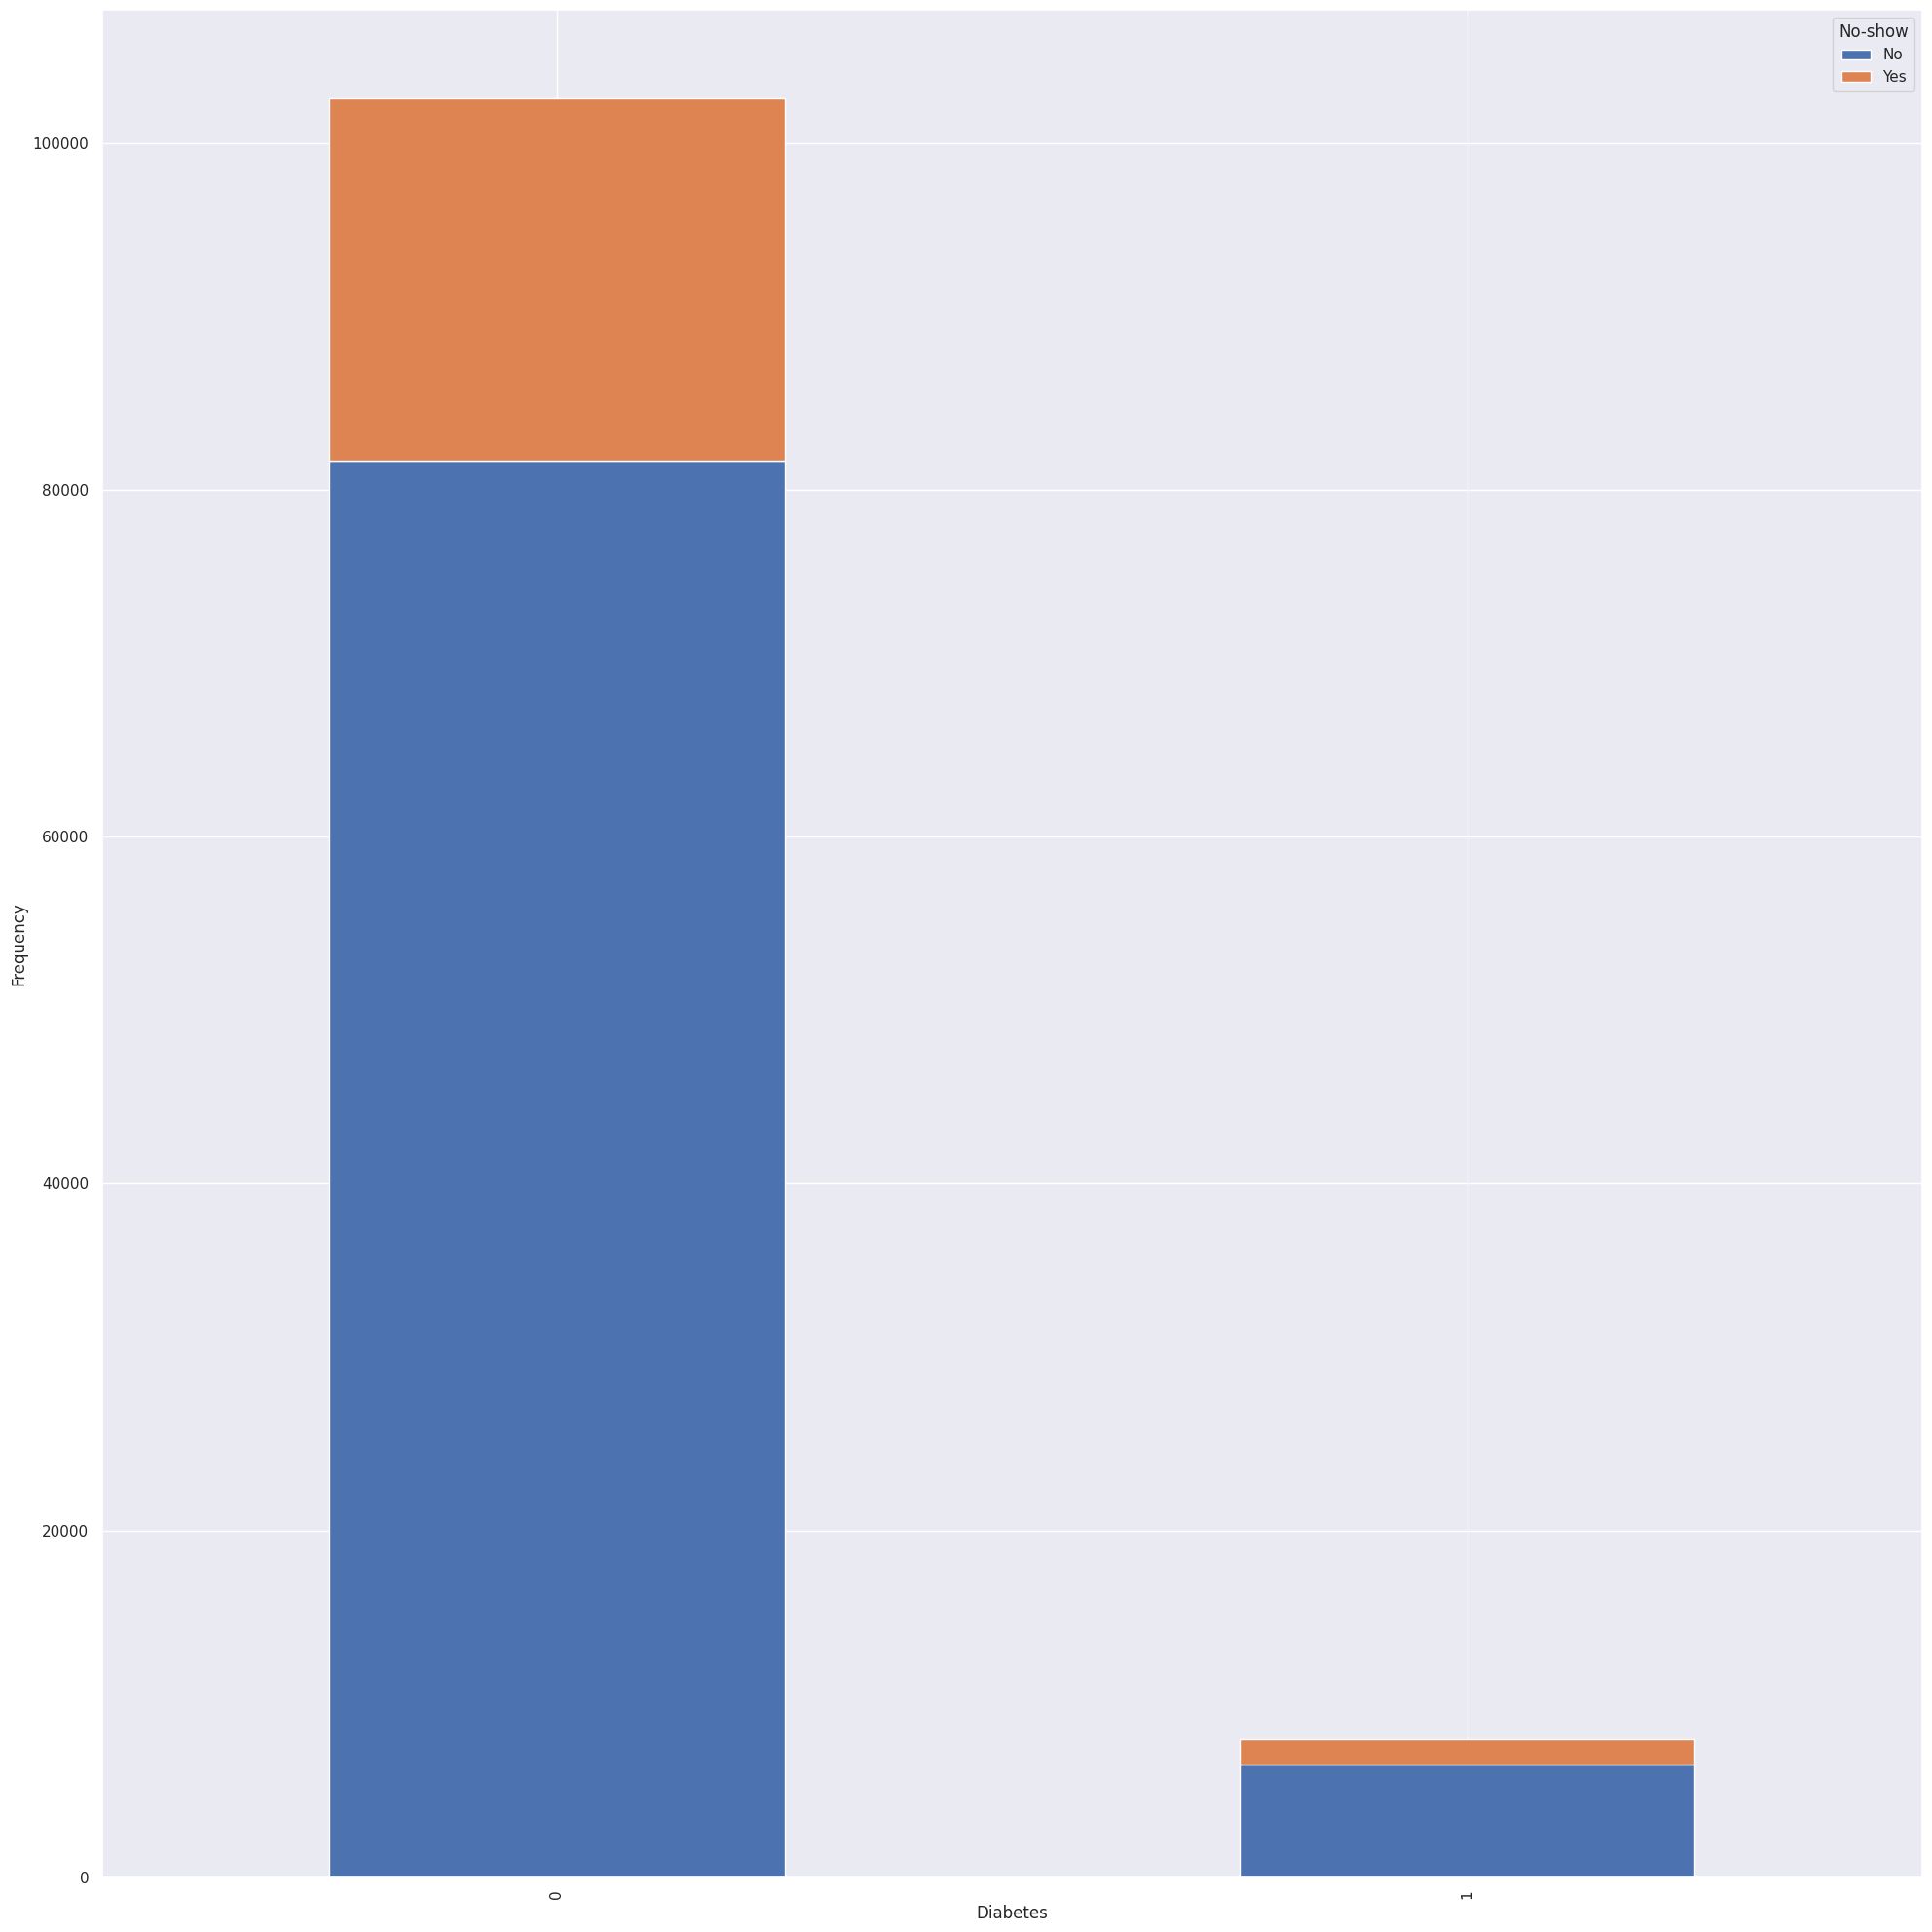

--------------------------------------------------------------------------

Alcoholism
No-show        No    Yes
Alcoholism              
0           85524  21642
1            2683    677


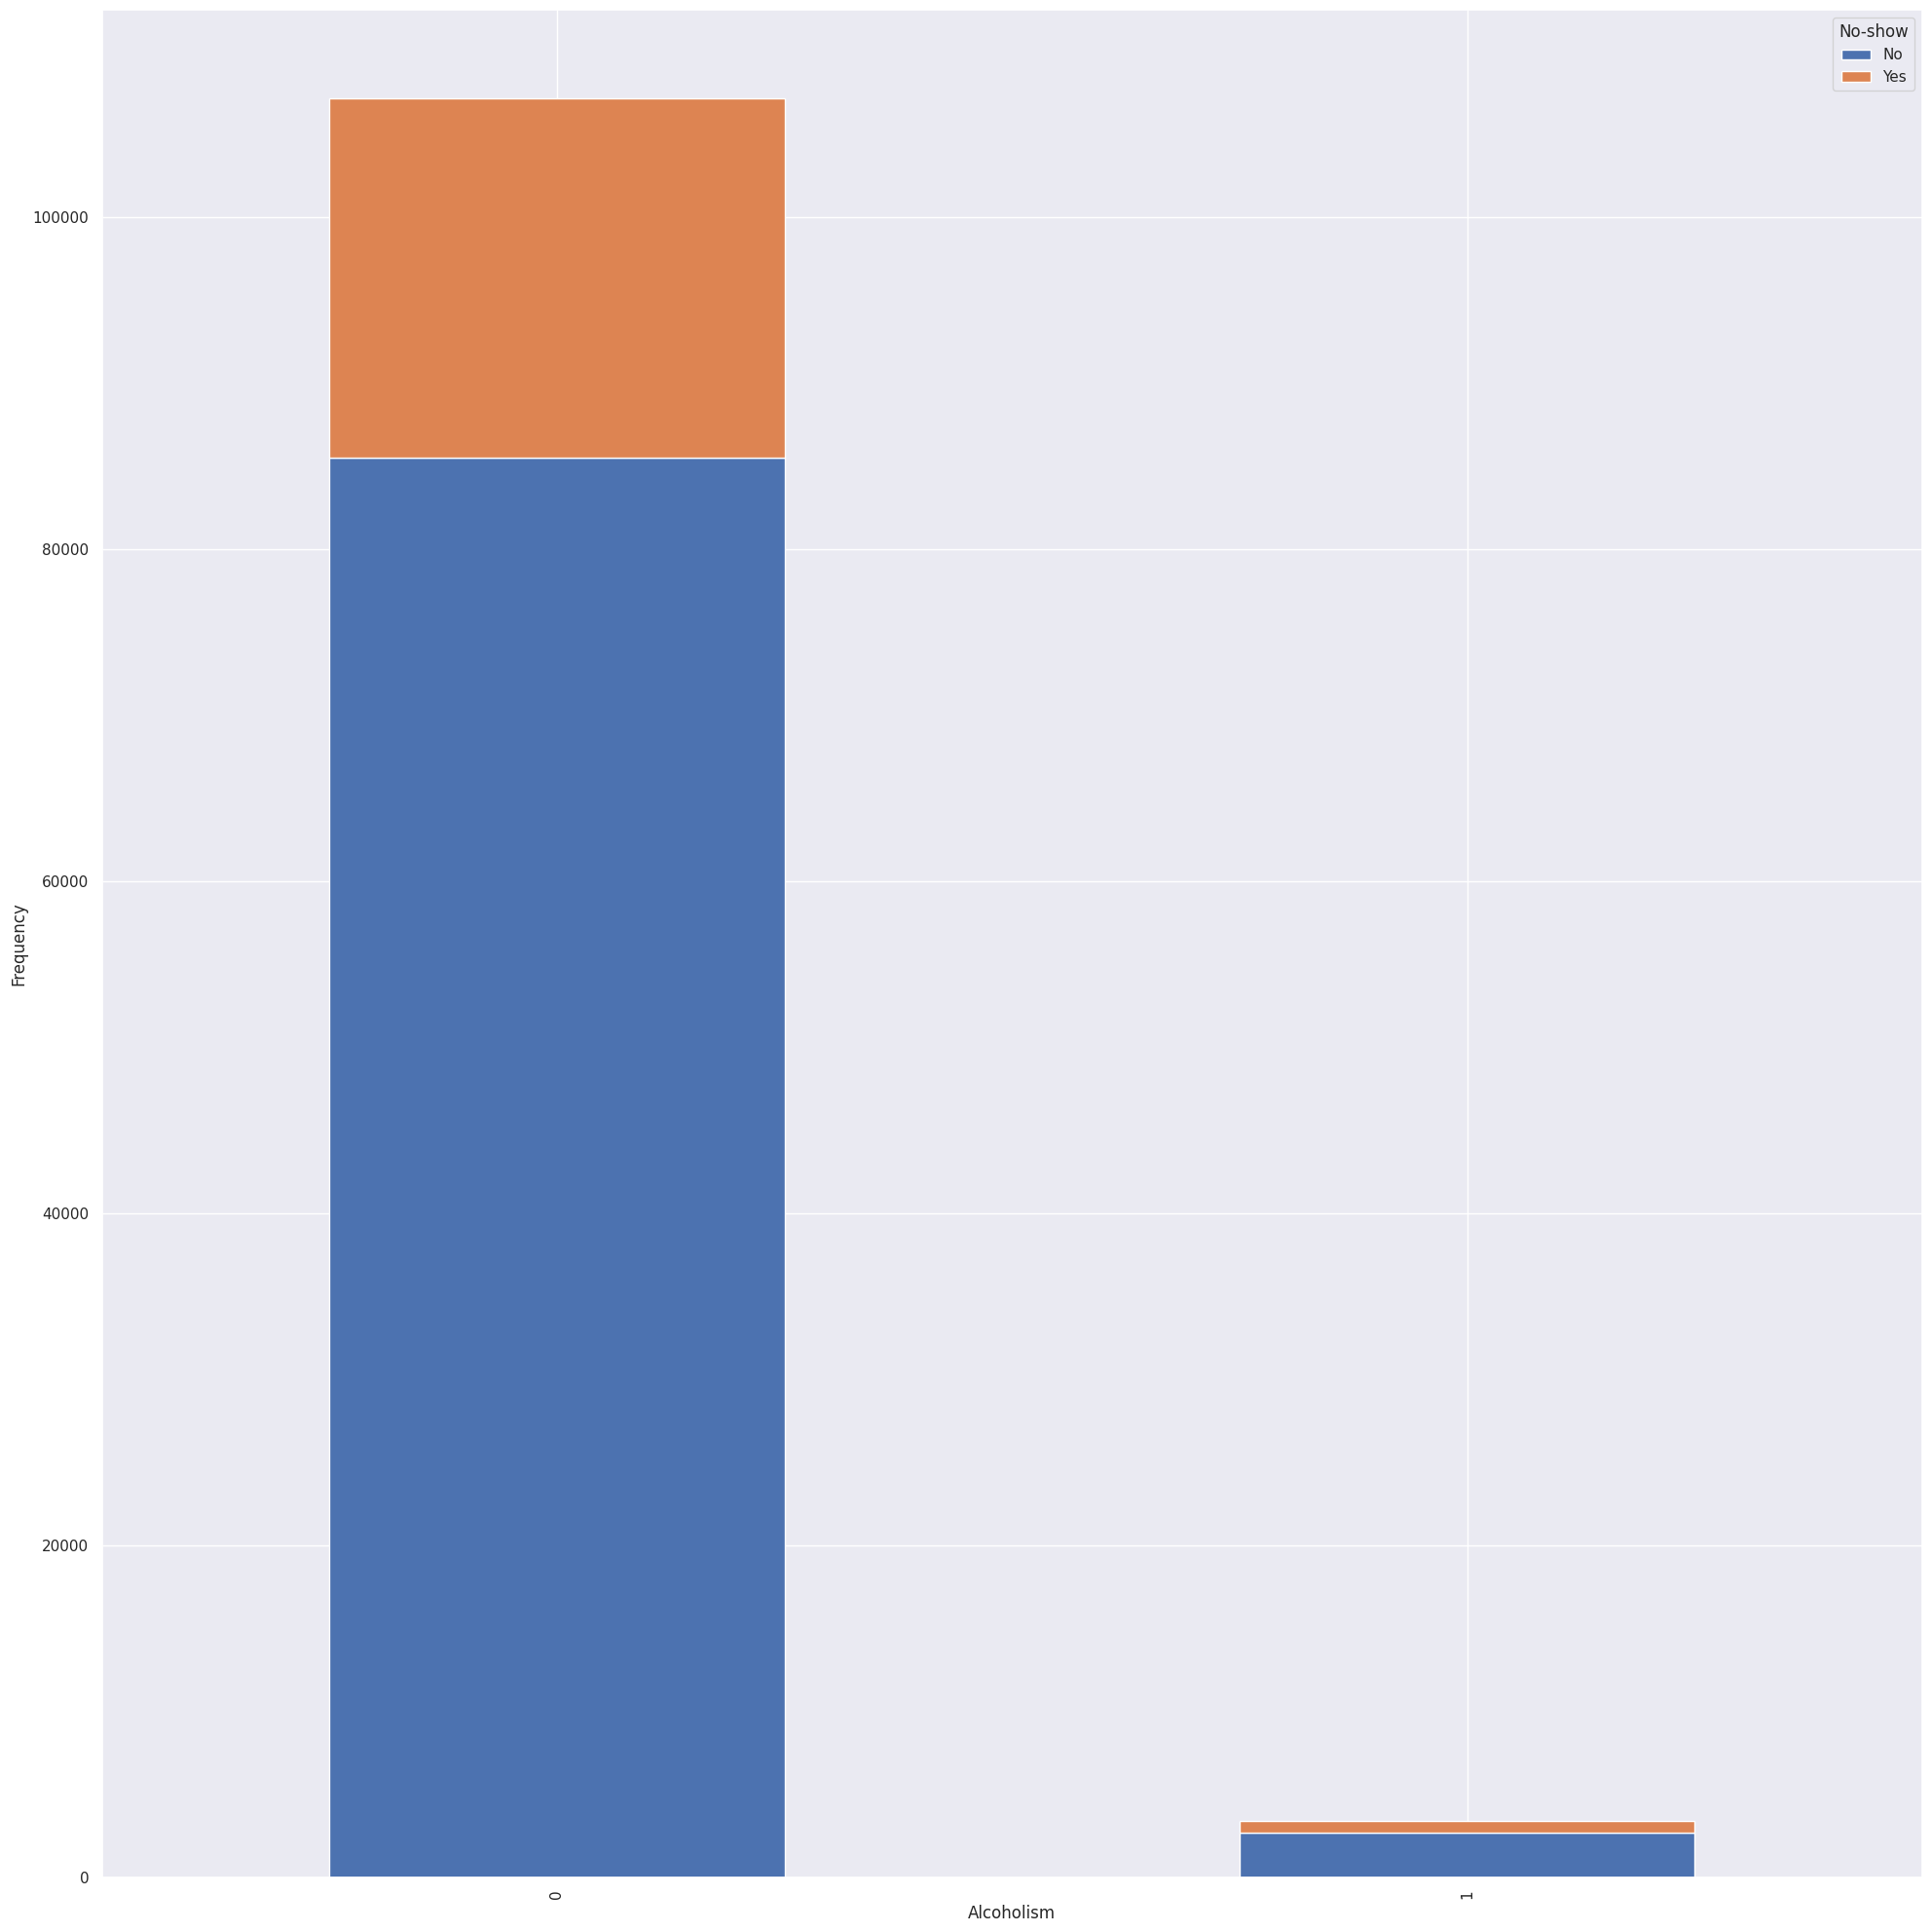

--------------------------------------------------------------------------

Handcap
No-show     No    Yes
Handcap              
0        86373  21912
1         1676    366
2          146     37
3           10      3
4            2      1


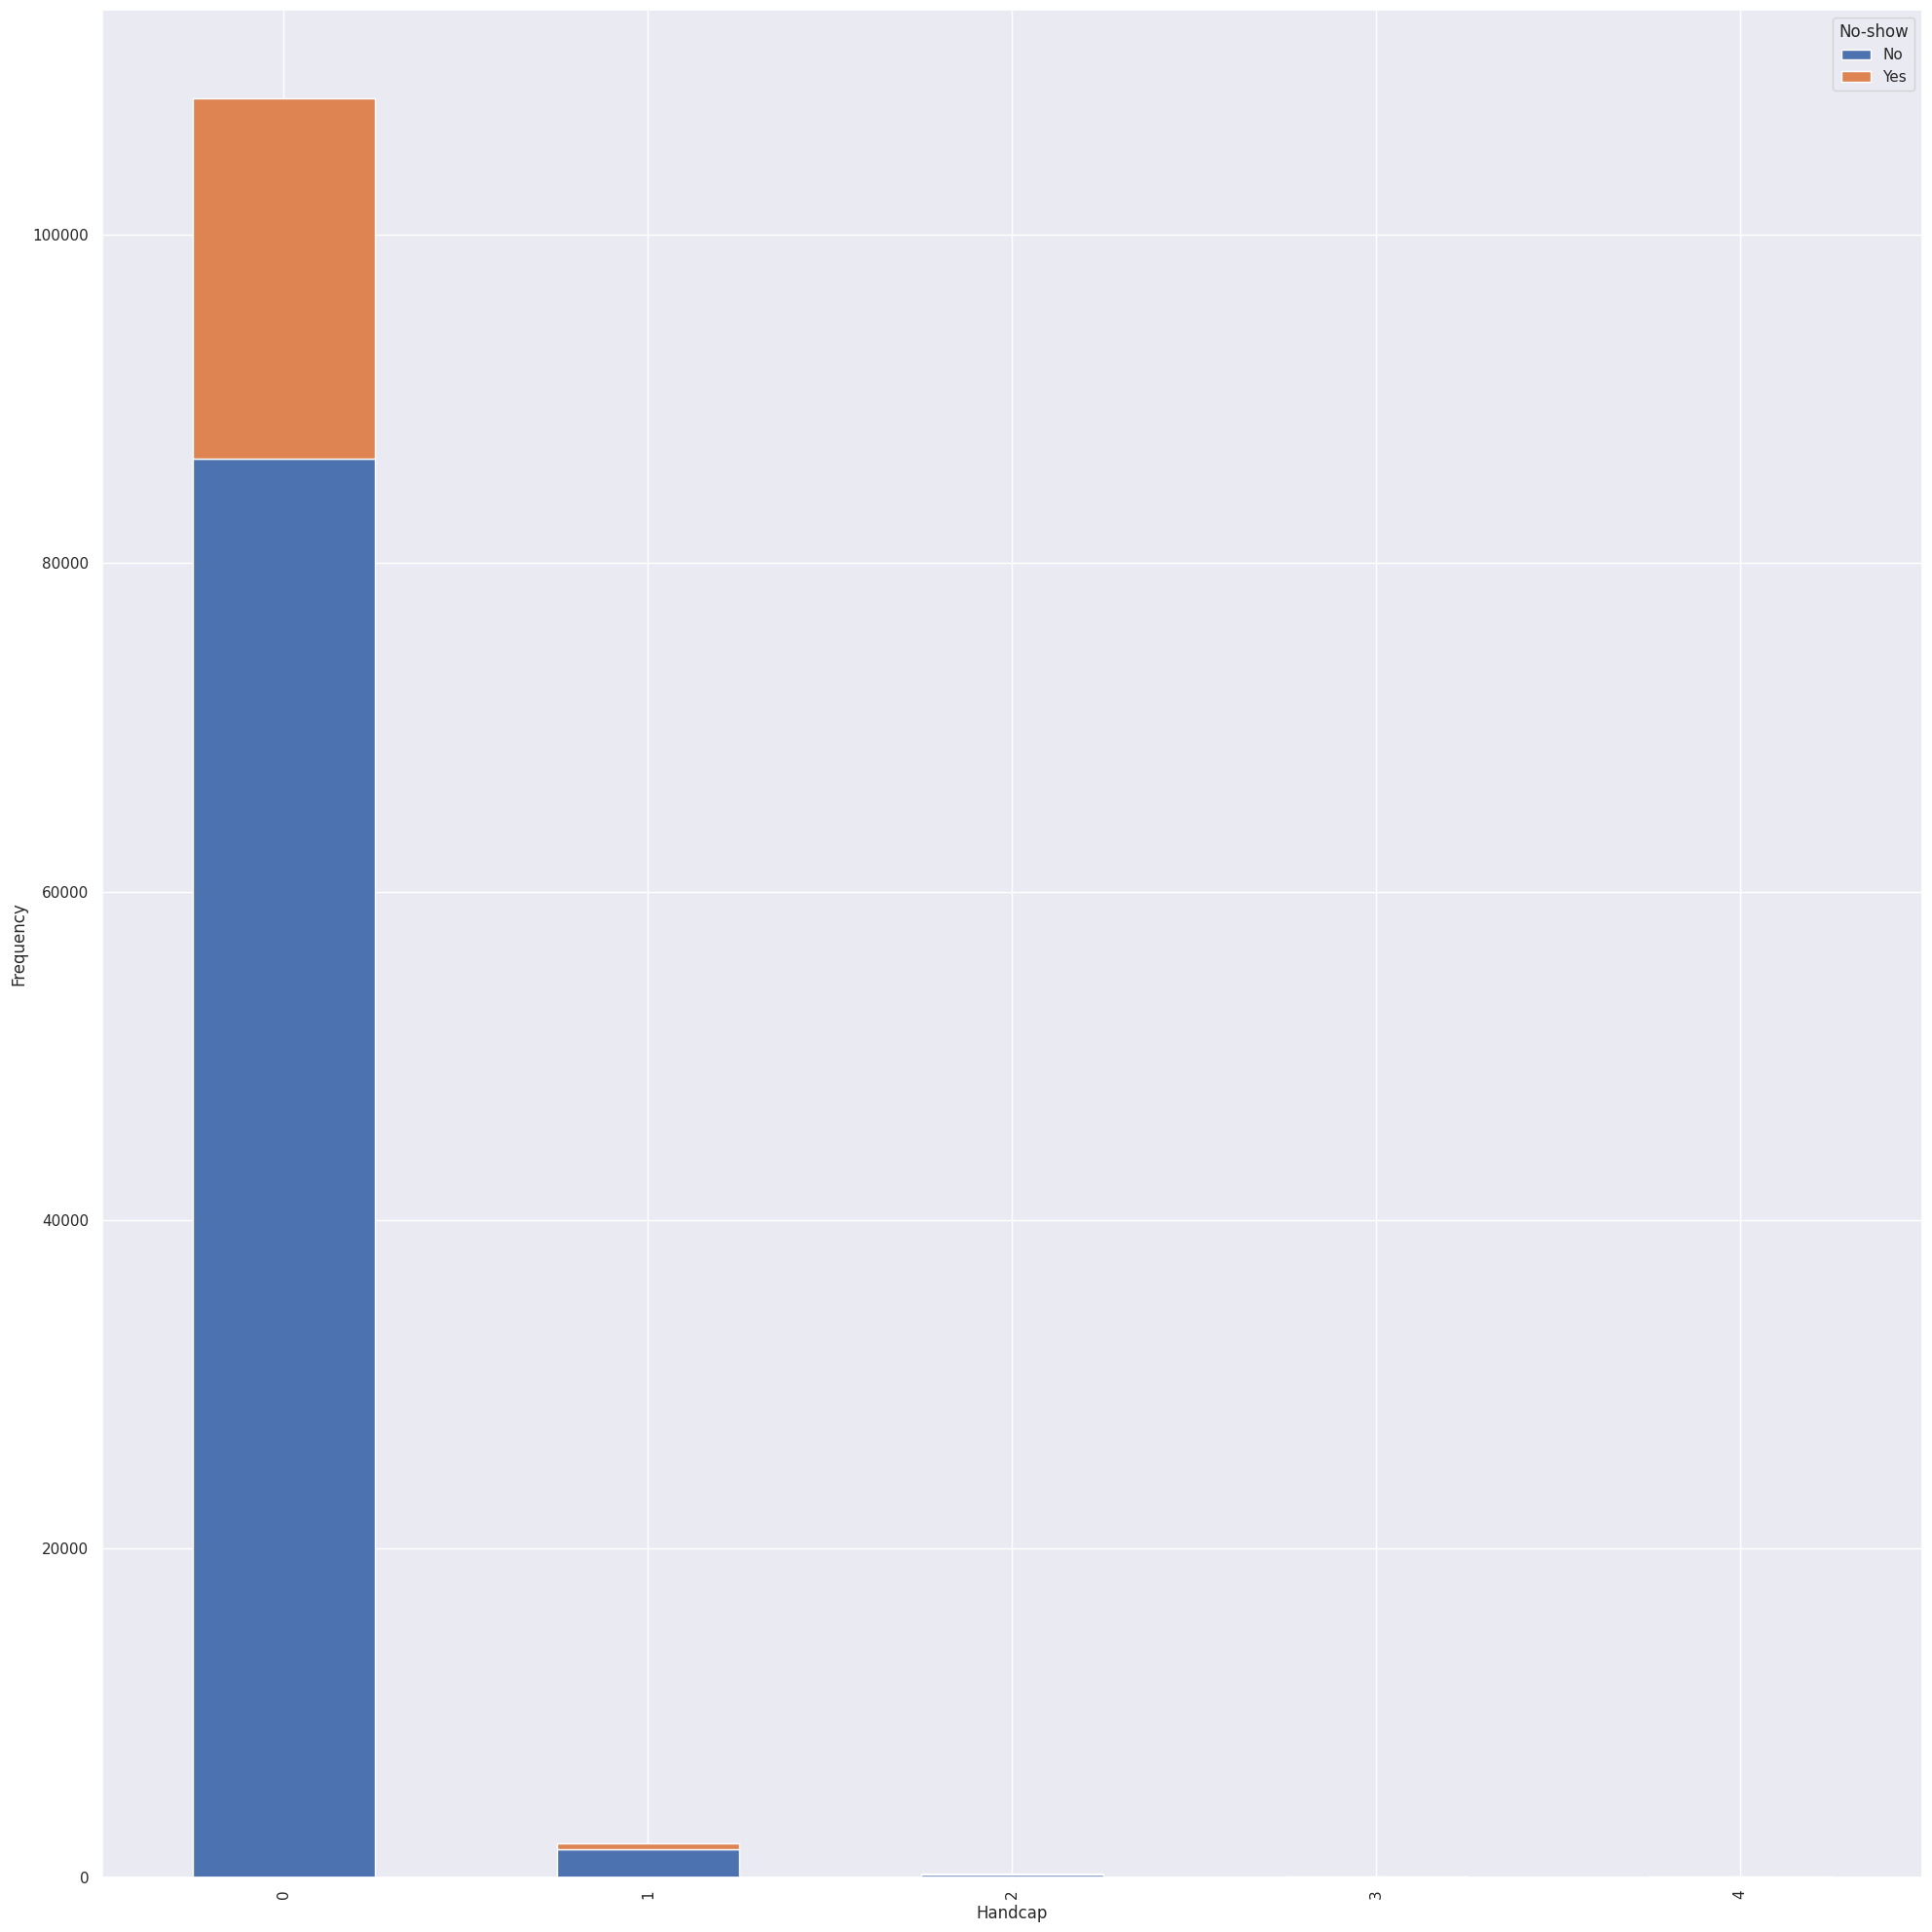

--------------------------------------------------------------------------

SMS_received
No-show          No    Yes
SMS_received              
0             62509  12535
1             25698   9784


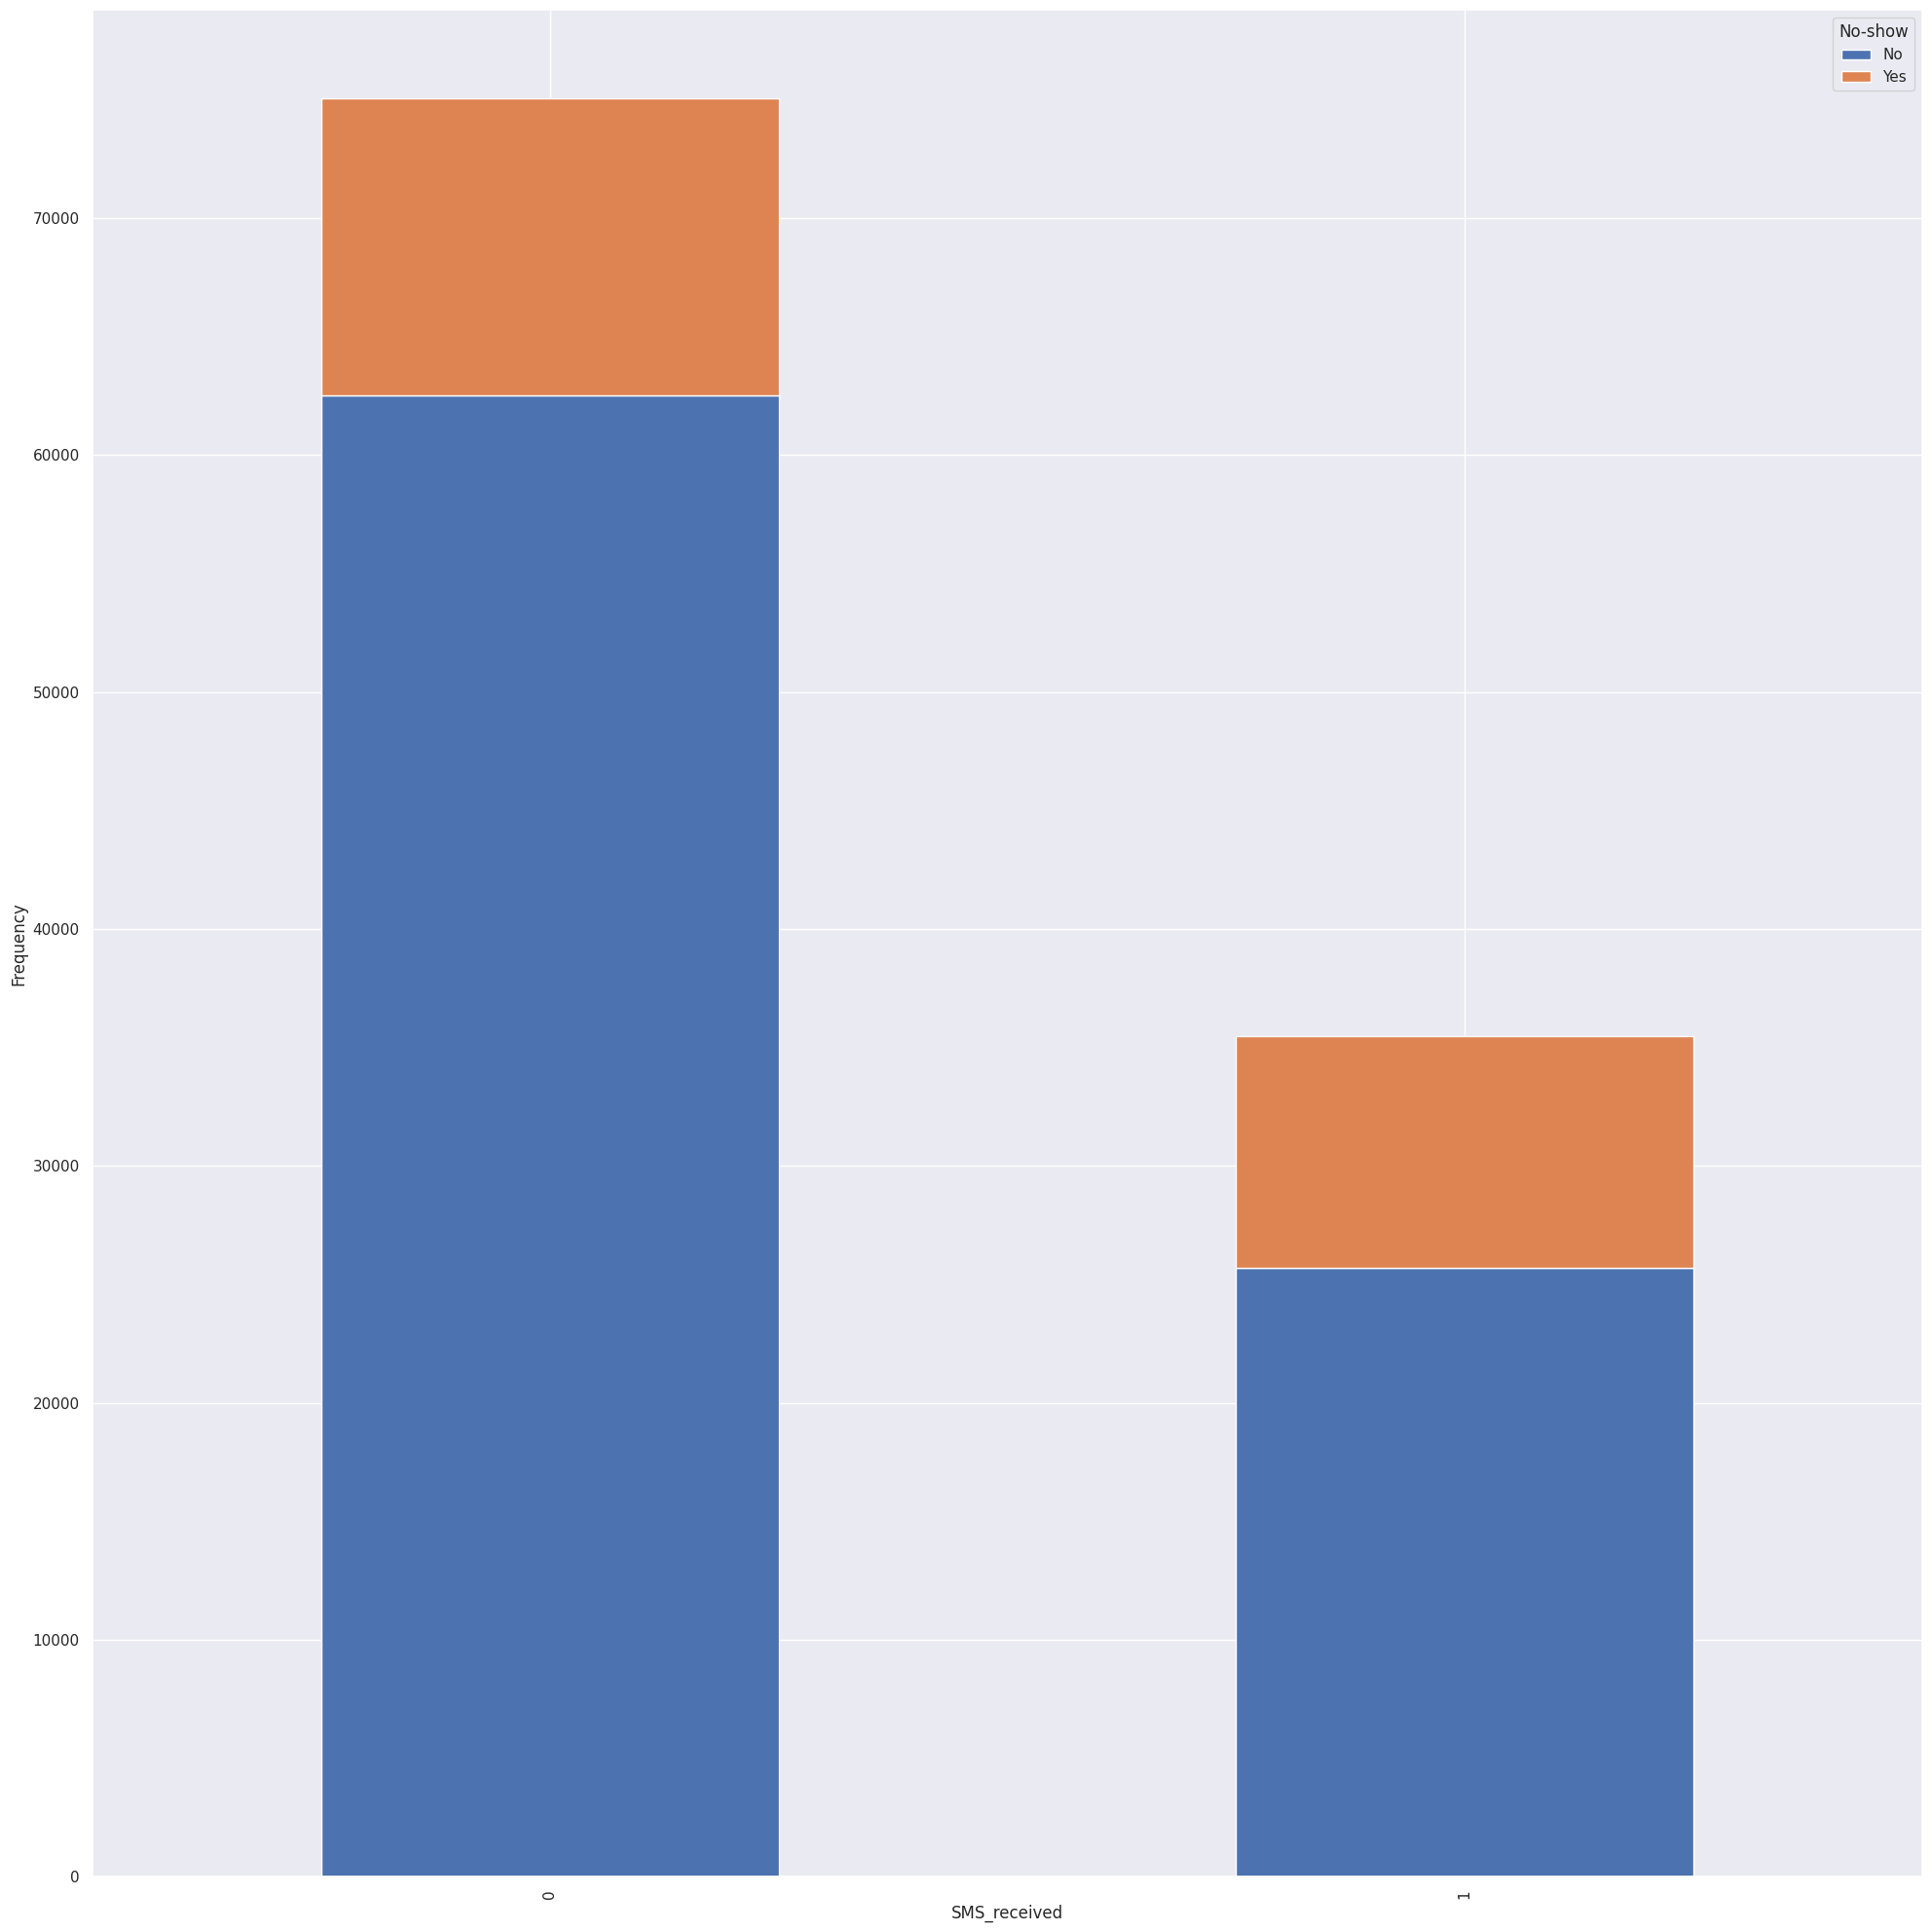

--------------------------------------------------------------------------



In [ ]:
def target_sum_cat(df, target, cat_col):
    group_target_cat = df.groupby([cat_col, target]).size().unstack(fill_value=0)
    print(cat_col)
    print(group_target_cat)
    group_target_cat.plot(kind='bar', stacked=True)
    plt.xlabel(cat_col)
    plt.ylabel('Frequency')
    plt.legend(title=target, loc='upper right')
    plt.tight_layout()
    plt.show()
    print("--------------------------------------------------------------------------\n")
for col in cat_cols:
    target_sum_cat(df, 'No-show', col)


Column name:  PatientId
###########
count    1.105260e+05
mean     1.474934e+14
std      2.560943e+14
min      3.921784e+04
5%       1.370166e+11
10%      5.188041e+11
20%      2.374422e+12
30%      5.837212e+12
40%      9.459167e+12
50%      3.173184e+13
60%      5.592948e+13
70%      8.189599e+13
80%      2.132851e+14
90%      6.187981e+14
95%      8.185549e+14
99%      9.633917e+14
max      9.999816e+14
Name: PatientId, dtype: float64


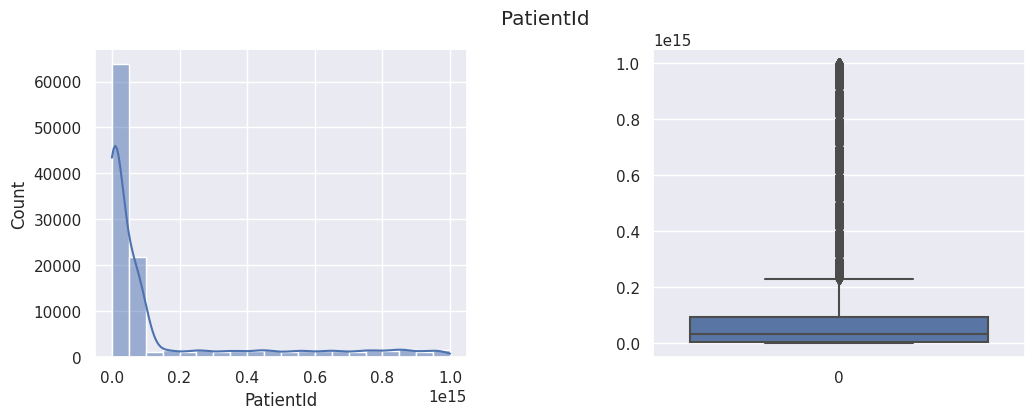

-------------------------------------

Column name:  Age
###########
count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
5%            1.000000
10%           5.000000
20%          13.000000
30%          21.000000
40%          30.000000
50%          37.000000
60%          45.000000
70%          52.000000
80%          59.000000
90%          68.000000
95%          75.000000
99%          86.000000
max         115.000000
Name: Age, dtype: float64


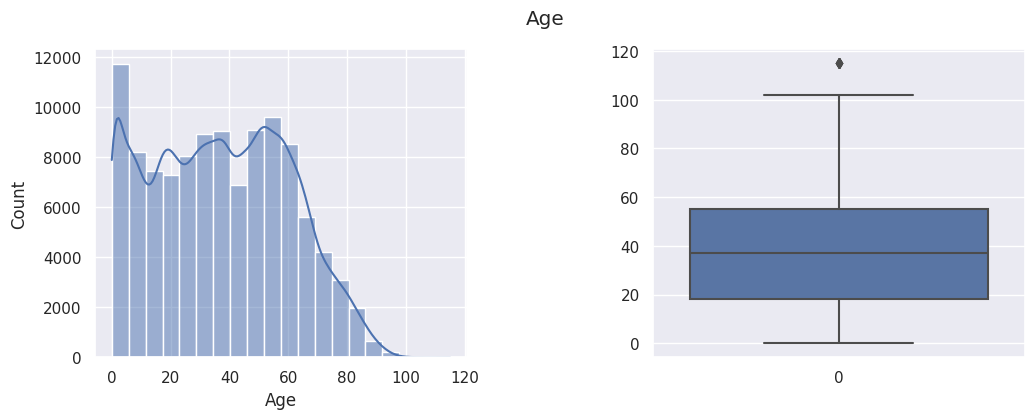

-------------------------------------



In [ ]:

# Numerical columns identification and visualization
def num_summary(dataframe, numerical_col):
    print(f'Column name: ', numerical_col)
    print("###########")
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    fig, ax = plt.subplots(1, 2, figsize = (12,4))
    fig.suptitle(numerical_col)
    sns.histplot(df[numerical_col], bins = 20, kde = True, ax = ax[0])
    sns.boxplot(df[col], ax = ax[1])
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show(block = True)
    print("-------------------------------------\n")
for col in num_cols:
    num_summary(df, col)

Although PatientID looks numeric, it actually represents each patient, so we cannot accept it as numeric.
The age variable was not normally distributed. 10% of the dataset includes children up to the age of 5. The average age of the dataset is 37. We can see that there are also people over 100 years old living in this region.


# **Correlation Matrix**

We could not look at the correlation matrix b.of the one numerical column. But if we rearrange the numeric column, we could observe correlation matrix


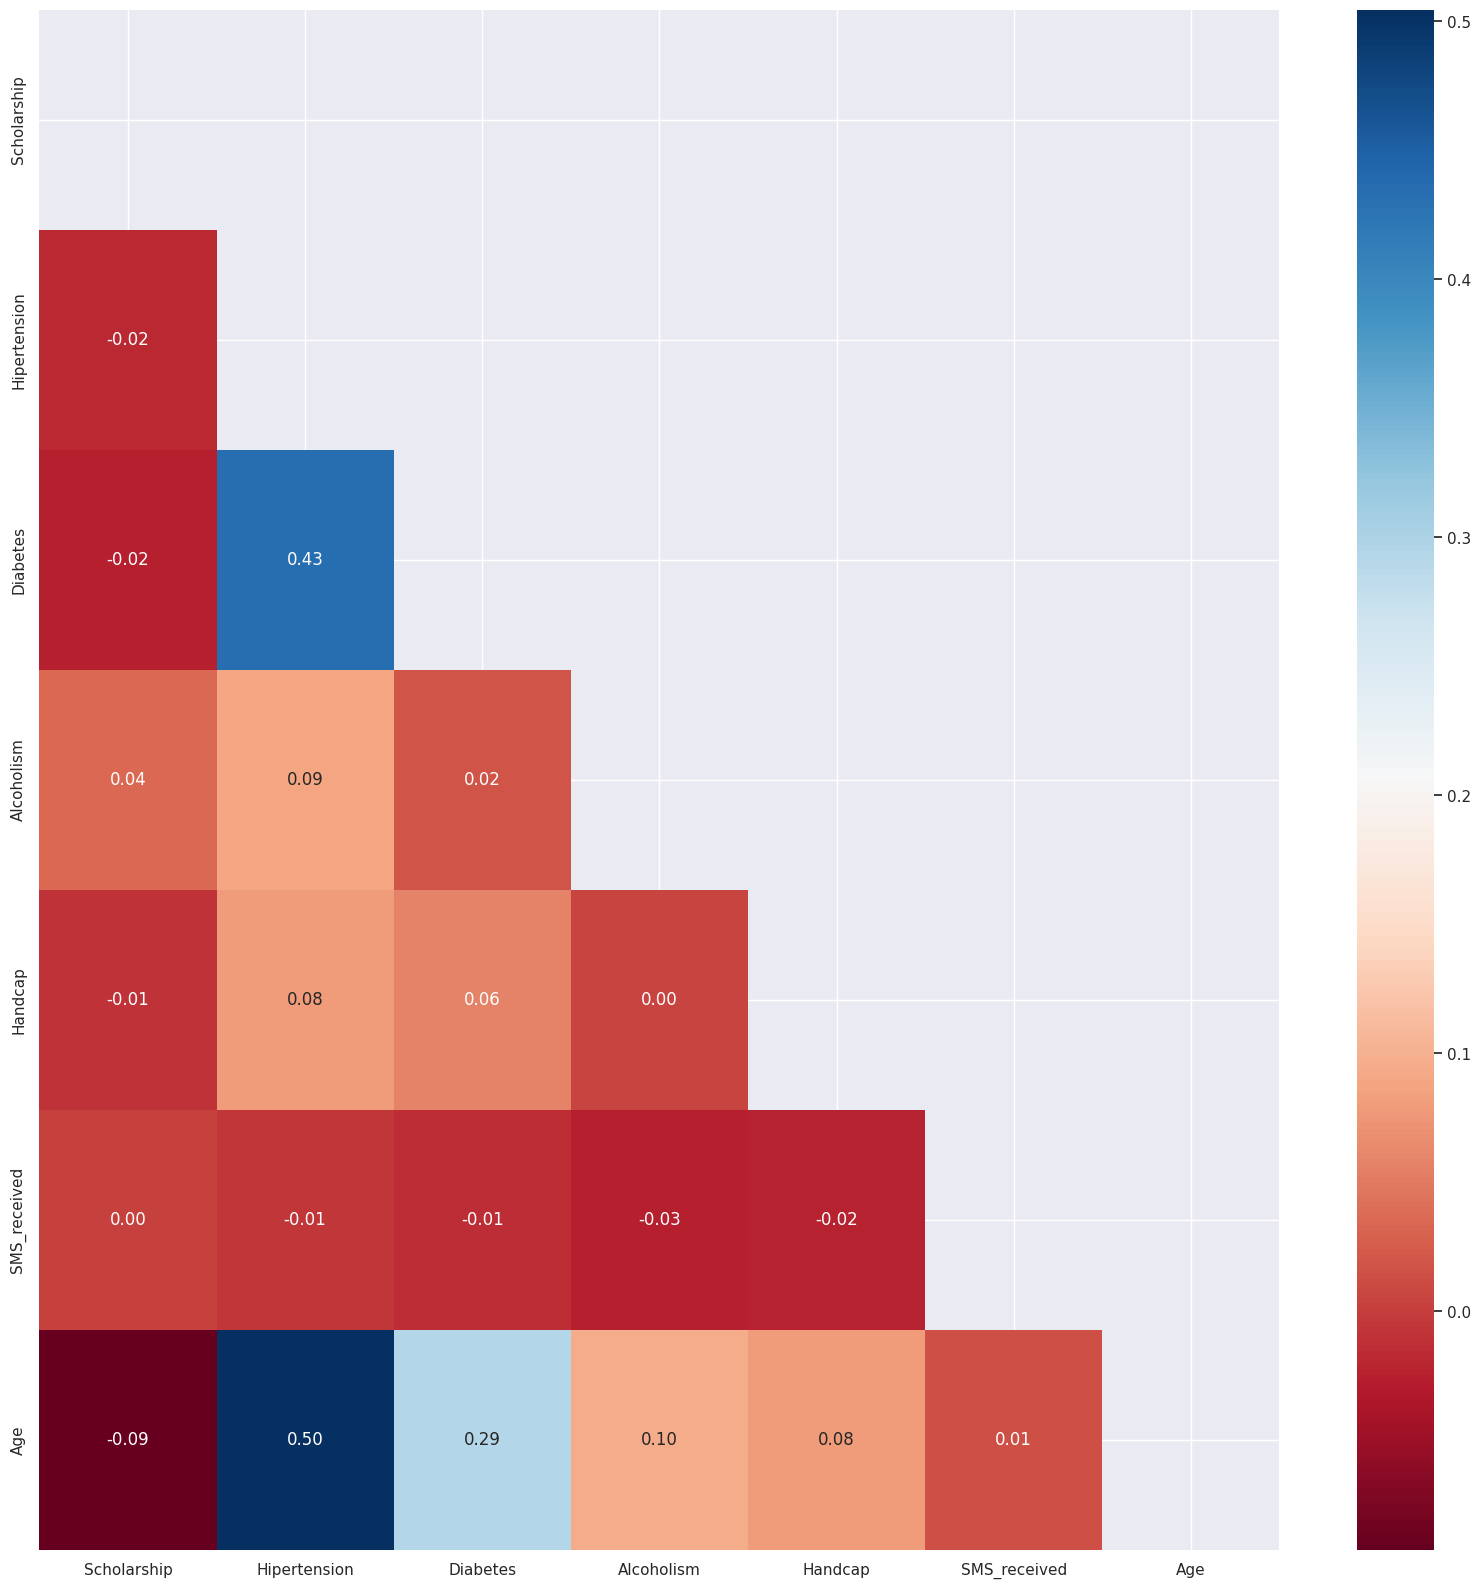

In [ ]:
def high_correlated_cols(df, num_cols, corr_th = 0.90, plot = False):
    corr = df[num_cols].corr()
    corr_matrix = corr.abs()
    upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype("bool"))
    mask = np.triu(np.ones_like(num_cols, dtype=bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        sns.set(rc = {"figure.figsize": (20,20)})
        sns.heatmap(corr, mask = mask,  cmap = "RdBu", annot = True, fmt=".2f")
        plt.show()
    return drop_list

corr_cols = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Age']
high_corr = high_correlated_cols(df,corr_cols, plot=True)

As might be expected, the correlation of the disease columns with age is highly correlated, especially with hypertension, but inversely correlated with scholarship.

# **Outlier Analysis**

In [ ]:
def outlier_thresholds(dataframe, variable, low_quantile=0.1, up_quantile=0.9):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
  print(f" {col} = {check_outlier(df, col)}")

 PatientId = False
 Age = False


# **Missing Value Analysis**

In [ ]:
df.isnull().sum()

PatientId         0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

There is no missing values.

# **Feature Engineering**

In [ ]:
#Create new variables
#1: Diff between appointment and scheculed days

df['N_diff_day'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df['N_diff_day'].describe().T

#There negatif numbers which is not possible so delete them

count    110526.000000
mean         10.183794
std          15.255034
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: N_diff_day, dtype: float64

In [ ]:
day_drop = df[df["N_diff_day"] < 0]
df.drop(index= day_drop.index, inplace= True)
df['N_diff_day'].describe().T

count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: N_diff_day, dtype: float64

In [ ]:
#2: Health score

df["N_health_score"] = df["Hipertension"] + df["Diabetes"] + df["Alcoholism"]
df["N_health_score"].unique()

array([1, 0, 2, 3])

In [ ]:
handcap_map = {
    0 : 0,
    1 : 1,
    2 : 1,
    3 : 1,
    4 : 1
}

df["Handcap"] = df["Handcap"].map(handcap_map)
df["Handcap"].unique()

array([0, 1])

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print(f"Categorical Columns:", cat_cols)
print(f"Numerical Columns:", num_cols)
print(f"Cardinal Columns:", cat_but_car)

Categorical Columns: ['Gender', 'Neighbourhood', 'No-show', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'N_health_score']
Numerical Columns: ['PatientId', 'Age', 'N_diff_day']
Cardinal Columns: []


In [ ]:
df2 = df.copy()

# **Modelling**

For modelling, we first need to scale and encode our data.

* I have used the StandardScaling module to scale our data, but I have used the features of the CatBoost model, which is the model that I am going to use for the coding.

In this model it is possible to encode categorical data, especially categorical data with many unique values, and use it in our model without increasing our dataset.

* To do this, we first determine our categorical variables and introduce them into our model using the Pool library.
* Then we perform model building and fitting operations.
* Finally, we calculate our accuracy, precision, recall, f1 and roc_auc metrics using our test data set.

In [ ]:
#Scaling

def scaler_std(dataframe, numerical_cols):
    scaler = StandardScaler()
    dataframe[numerical_cols] = scaler.fit_transform(dataframe[numerical_cols])
    return dataframe

df = scaler_std(df, num_cols)

# Prepare data
X = df.drop(columns=['No-show'])
y = df['No-show']

In [ ]:
def train_and_evaluate_catboost(data, X, y, categorical_features):

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pool
    train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

    # Modelling CatBoost
    model = CatBoostClassifier(loss_function='Logloss', random_state=42)
    model.fit(train_pool, eval_set=test_pool, verbose=200)

    # prediction
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Pozitif sınıfın olasılıkları
    y_pred = model.predict(X_test)

    # calculation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='Yes')
    recall = recall_score(y_test, y_pred, pos_label='Yes')
    f1 = f1_score(y_test, y_pred, pos_label='Yes')
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')


cat_features = [X.columns.get_loc(col) for col in cat_cols if col in X.columns]

train_and_evaluate_catboost(df, X, y, categorical_features=cat_features)

Learning rate set to 0.095874
0:	learn: 0.6406971	test: 0.6410370	best: 0.6410370 (0)	total: 55.4ms	remaining: 55.3s
200:	learn: 0.4317286	test: 0.4413824	best: 0.4413824 (200)	total: 10.7s	remaining: 42.5s
400:	learn: 0.4217397	test: 0.4400710	best: 0.4400121 (397)	total: 22.2s	remaining: 33.1s
600:	learn: 0.4142113	test: 0.4397411	best: 0.4396957 (569)	total: 33.8s	remaining: 22.4s
800:	learn: 0.4075163	test: 0.4398315	best: 0.4396835 (622)	total: 44.9s	remaining: 11.2s
999:	learn: 0.4011875	test: 0.4397939	best: 0.4396107 (847)	total: 56.6s	remaining: 0us

bestTest = 0.4396106564
bestIteration = 847

Shrink model to first 848 iterations.
Accuracy: 0.7990
Precision: 0.5527
Recall: 0.0479
F1 Score: 0.0882
ROC AUC: 0.7391


# **Hyperparameter Optimization**

We improved our model by optimizing hyperparameters with Optuna

In [ ]:
cat_features3 = [X.columns.get_loc(col) for col in cat_cols if col in X.columns]
# Veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CatBoost Pool tanımlama
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features3)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features3)

# Hedef fonksiyon (Optuna için)
def objective(trial):
    # Optuna ile optimize edilecek hiperparametreler
    params = {
        "iterations": trial.suggest_int("iterations", 500, 1000),
        "depth": trial.suggest_int("depth", 4, 6, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1)

    }

    # CatBoostClassifier modeli oluşturma
    model = CatBoostClassifier(**params)

    # Modeli eğitme
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=False)

    # Test seti üzerinde tahmin yapma
    preds = model.predict(X_test)

    # Modelin doğruluğunu hesaplama
    accuracy = accuracy_score(y_test, preds)

    return accuracy

# Optuna çalıştırma
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# En iyi hiperparametreler
best_params = study.best_params
print("En iyi hiperparametreler: ", best_params)



[I 2024-09-19 15:38:32,909] A new study created in memory with name: no-name-fcafb146-56fc-48a4-ba08-c32cb399f192
[I 2024-09-19 15:39:11,276] Trial 0 finished with value: 0.7985523637186157 and parameters: {'iterations': 918, 'depth': 4, 'learning_rate': 0.06902638304079295, 'bagging_temperature': 0.40469153188085716}. Best is trial 0 with value: 0.7985523637186157.
[I 2024-09-19 15:39:45,836] Trial 1 finished with value: 0.7982809319158561 and parameters: {'iterations': 822, 'depth': 4, 'learning_rate': 0.0732591345493427, 'bagging_temperature': 0.3709854448081237}. Best is trial 0 with value: 0.7985523637186157.
[I 2024-09-19 15:40:10,857] Trial 2 finished with value: 0.7972404433386112 and parameters: {'iterations': 608, 'depth': 4, 'learning_rate': 0.010602417894450046, 'bagging_temperature': 0.9169231957025369}. Best is trial 0 with value: 0.7985523637186157.
[I 2024-09-19 15:40:34,244] Trial 3 finished with value: 0.7974666365075774 and parameters: {'iterations': 563, 'depth': 4,

En iyi hiperparametreler:  {'iterations': 857, 'depth': 4, 'learning_rate': 0.09613285934680918, 'bagging_temperature': 0.6034563296586388}


In [ ]:
# En iyi modelle final eğitim ve test
best_model = CatBoostClassifier(**best_params)
best_model.fit(train_pool)

# Final model tahmini ve doğruluk
final_preds = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_preds)
print("Final doğruluk: ", final_accuracy)

0:	learn: 0.6383171	total: 43.6ms	remaining: 37.3s
1:	learn: 0.5981931	total: 85ms	remaining: 36.4s
2:	learn: 0.5672526	total: 126ms	remaining: 35.9s
3:	learn: 0.5405651	total: 166ms	remaining: 35.5s
4:	learn: 0.5248473	total: 204ms	remaining: 34.8s
5:	learn: 0.5079095	total: 248ms	remaining: 35.2s
6:	learn: 0.4977839	total: 293ms	remaining: 35.6s
7:	learn: 0.4901156	total: 323ms	remaining: 34.3s
8:	learn: 0.4811443	total: 362ms	remaining: 34.1s
9:	learn: 0.4753699	total: 405ms	remaining: 34.3s
10:	learn: 0.4692214	total: 446ms	remaining: 34.3s
11:	learn: 0.4662382	total: 487ms	remaining: 34.3s
12:	learn: 0.4638513	total: 527ms	remaining: 34.2s
13:	learn: 0.4616797	total: 572ms	remaining: 34.4s
14:	learn: 0.4584299	total: 612ms	remaining: 34.3s
15:	learn: 0.4559040	total: 654ms	remaining: 34.4s
16:	learn: 0.4539297	total: 691ms	remaining: 34.1s
17:	learn: 0.4523169	total: 732ms	remaining: 34.1s
18:	learn: 0.4516393	total: 769ms	remaining: 33.9s
19:	learn: 0.4508784	total: 808ms	remaini

# **Unsupervised Learning**

Prepare data for K-Means Algorithm

In [ ]:

#import libraries for unsupervised learning
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110521 non-null  float64       
 1   Gender          110521 non-null  object        
 2   ScheduledDay    110521 non-null  datetime64[ns]
 3   AppointmentDay  110521 non-null  datetime64[ns]
 4   Age             110521 non-null  int64         
 5   Neighbourhood   110521 non-null  object        
 6   Scholarship     110521 non-null  int64         
 7   Hipertension    110521 non-null  int64         
 8   Diabetes        110521 non-null  int64         
 9   Alcoholism      110521 non-null  int64         
 10  Handcap         110521 non-null  int64         
 11  SMS_received    110521 non-null  int64         
 12  No-show         110521 non-null  object        
 13  N_diff_day      110521 non-null  int64         
 14  N_health_score  110521 non-null  int64   

# **K-Means**

In [ ]:
#K-Means need numerical columns so delete all datetime and unique columns
drop_col = ["ScheduledDay", "AppointmentDay","PatientId", "Neighbourhood"]
for col in drop_col:
    df2.drop(columns = col, inplace= True)

In [ ]:
cat_col, num_col, car_col = grab_col_names(df2)
print(f"Categorical Columns:", cat_cols)
print(f"Numerical Columns:", num_cols)
print(f"Cardinal Columns:", cat_but_car)

Categorical Columns: ['Gender', 'Neighbourhood', 'No-show', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'N_health_score']
Numerical Columns: ['PatientId', 'Age', 'N_diff_day']
Cardinal Columns: []


In [ ]:
gender_map = {
    "M" : 0,
    "F" : 1}

df2["Gender"] = df2["Gender"].map(gender_map)


no_map = {
    "No" : 0,
    "Yes" : 1}

df2["No-show"] = df2["No-show"].map(no_map)

In [ ]:
cat_to_num = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'N_health_score']

for col in cat_to_num:
    df2[col] = df2[col].astype(int)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   Gender          110521 non-null  int64
 1   Age             110521 non-null  int64
 2   Scholarship     110521 non-null  int64
 3   Hipertension    110521 non-null  int64
 4   Diabetes        110521 non-null  int64
 5   Alcoholism      110521 non-null  int64
 6   Handcap         110521 non-null  int64
 7   SMS_received    110521 non-null  int64
 8   No-show         110521 non-null  int64
 9   N_diff_day      110521 non-null  int64
 10  N_health_score  110521 non-null  int64
dtypes: int64(11)
memory usage: 10.1 MB


In [ ]:
df3 = df2.copy()

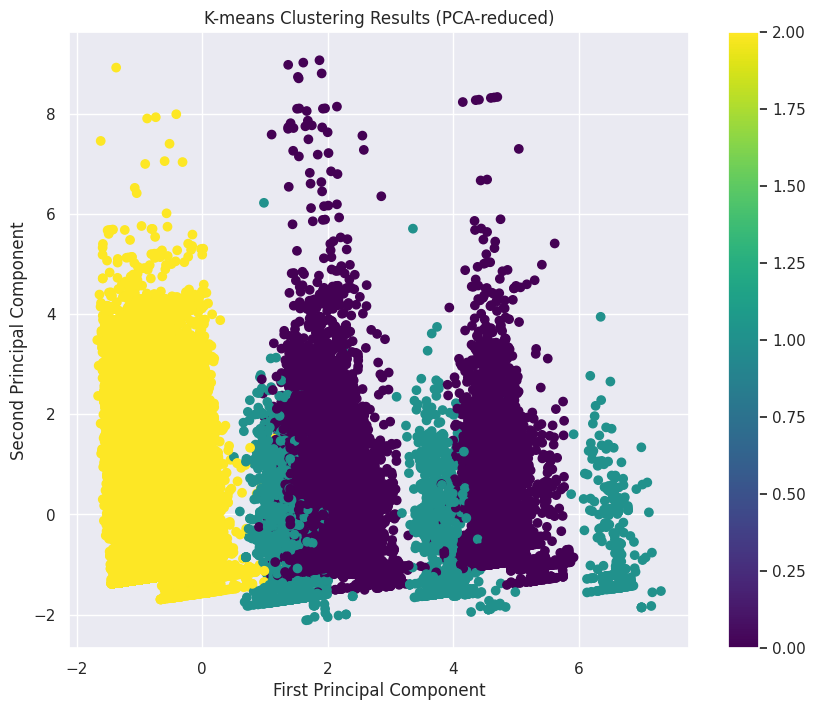

In [ ]:
# Numerical columns

numerical_columns = ['No-show', 'Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'N_diff_day', 'N_health_score']

# StandartScaling
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df2[numerical_columns])

# Combine transformed data
X = scaled_numerical

# Creating and implementing the K-means model
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

# Reduction to 2 dimensions with PCA (for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering Results (PCA-reduced)')
plt.colorbar(scatter)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [ ]:
# Examine the properties of each cluster
df2['Cluster'] = labels
cluster_info = df2.groupby('Cluster').mean()
print(cluster_info)

           Gender        Age  Scholarship  Hipertension  Diabetes  Alcoholism  \
Cluster                                                                         
0        0.721516  60.448339     0.082365      0.936854  0.348220         0.0   
1        0.363988  49.593750     0.157143      0.394940  0.098810         1.0   
2        0.642913  30.612763     0.100027      0.000000  0.000012         0.0   

          Handcap  SMS_received   No-show  N_diff_day  N_health_score  
Cluster                                                                
0        0.044202      0.317242  0.174018    9.751624        1.285074  
1        0.023214      0.252083  0.201488    6.865179        1.493750  
2        0.014008      0.324733  0.209057   10.425932        0.000012  


# **Elbow Method and Silhouette Analyzing**

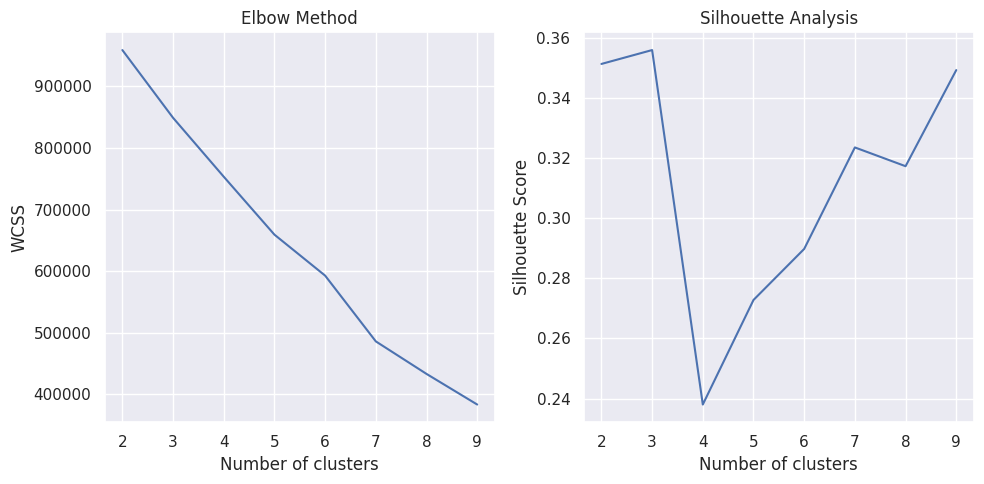

Best Silhouette Score: 0.35591023670755356
Best number of clusters based on Silhouette Analysis: 3


In [ ]:
# WCSS calculation for Elbow Method
wcss = []
silhouette_scores = []
max_clusters = 10  # Maximum number of clusters to try

for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Graph of Elbw Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Graph of Silhouette Analyzing
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Find the best Silhouette score and the corresponding number of clusters
best_silhouette_scores = max(silhouette_scores)
best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Best Silhouette Score: {best_silhouette_scores}")
print(f"Best number of clusters based on Silhouette Analysis: {best_n_clusters}")

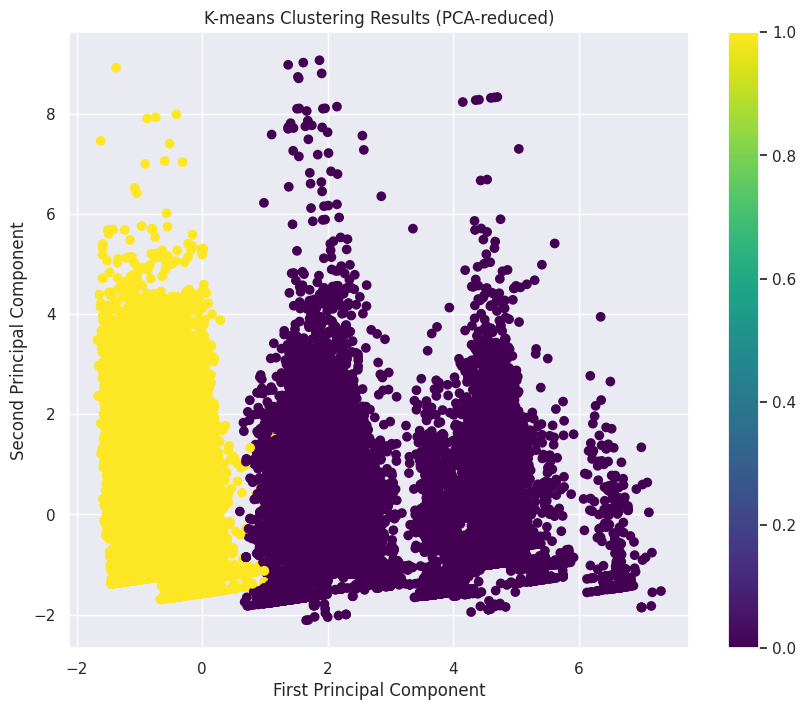

In [ ]:
# Building the model again with the best n-cluster number found
kmeans = KMeans(n_clusters=, random_state=42)
labels = kmeans.fit_predict(X)

# PCA for visiualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)

# Visiualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering Results (PCA-reduced)')
plt.colorbar(scatter)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()